# Deep Learnig Project - Part 1
- Maximiliano Niemetz - 342731312
- Chen Halfi - 207024571

## Impots and Load

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from itertools import combinations
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import torch
from transformers import BertTokenizer, BertModel
import warnings
warnings.filterwarnings('ignore')
import string
from nltk.corpus import stopwords
import re
import emoji
import spacy
from collections import Counter, defaultdict
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
# Load dataset
df = pd.read_csv("Corona_NLP_train.csv", encoding='ISO-8859-1')
df_test = pd.read_csv("Corona_NLP_test.csv", encoding='ISO-8859-1')

## EDA

### Basic Satatistics

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


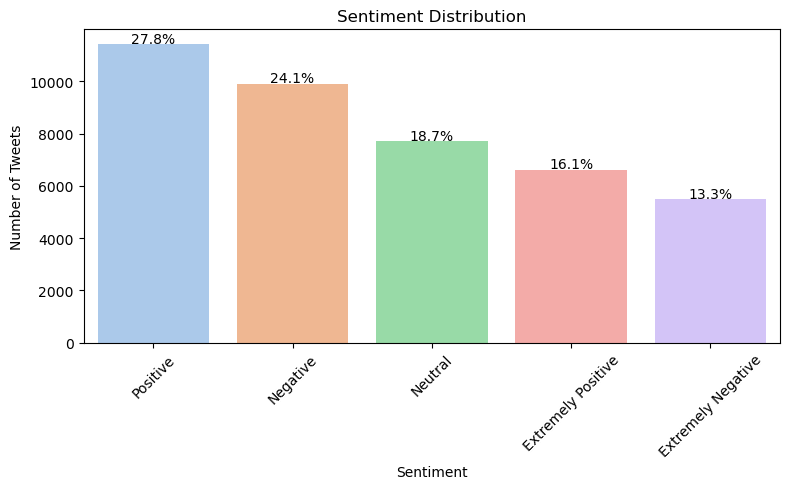

In [5]:
# Calculate counts and percentages
sentiment_counts = df['Sentiment'].value_counts()
sentiment_percent = sentiment_counts / sentiment_counts.sum() * 100

# Create the plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='pastel')

# Add percentage labels on top of bars
for i, p in enumerate(sentiment_counts):
    percentage = sentiment_percent[i]
    ax.text(i, p + 50, f'{percentage:.1f}%', ha='center', fontsize=10)

# Titles and labels
plt.title('Sentiment Distribution')
plt.ylabel('Number of Tweets')
plt.xlabel('Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Sentiment Distribution in COVID-19 Tweets – Reflections**

This chart shows how sentiments were distributed across tweets related to COVID-19.

- The most common sentiment was **Positive** (about **27.8%** of tweets). This suggests that even during a global crisis, many people shared messages of hope, encouragement, and gratitude – possibly toward healthcare workers or community efforts.

- On the other hand, around **37%** of tweets were **Negative** (including both regular and extremely negative). This reflects strong emotional responses like fear, frustration, and criticism – understandable given the circumstances.

- About **19%** of tweets were **Neutral**, likely representing factual updates, news reports, or emotionally neutral statements.

- Interestingly, **Extremely Positive** tweets made up only about **16%**, indicating that while many tried to stay optimistic, people may have avoided overly enthusiastic tones during a difficult time.

- The dataset is **imbalanced**, with more tweets in the regular Positive/Negative categories than in the Extreme ones. If we plan to train a sentiment classifier, we’ll need to handle this imbalance carefully.

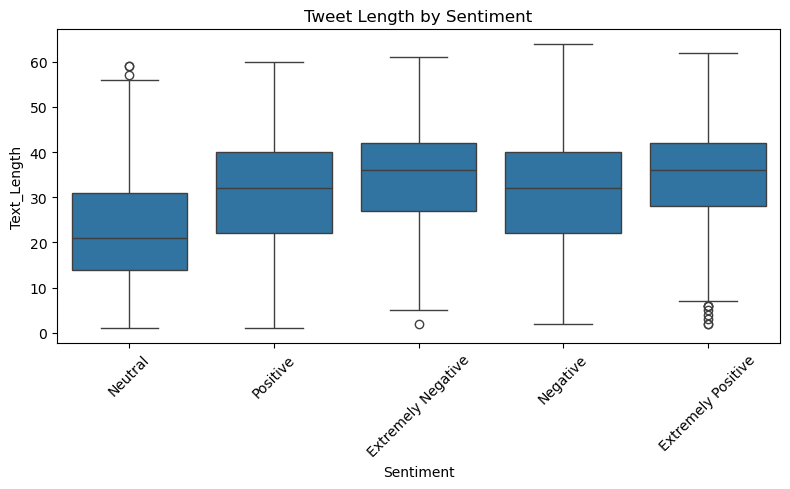

In [7]:
# Length of tweets
df['Text_Length'] = df['OriginalTweet'].astype(str).apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Sentiment', y='Text_Length')
plt.title('Tweet Length by Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**key Insights from Tweet Length by Sentiment:**

- Tweet lengths across all sentiment categories (**Neutral**, **Positive**, **Extremely Negative**, **Negative**, **Extremely Positive**) are similar, with most tweets between 20-40 characters.
- **Neutral** tweets have the longest median length (30 characters), while **Extremely Negative** tweets have a slightly shorter median (25 characters).
- There are some **outliers** with longer or shorter tweets, but overall, tweet length does not vary significantly by sentiment.

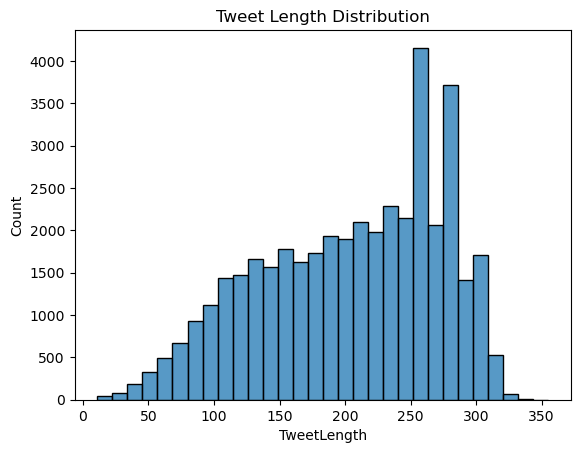

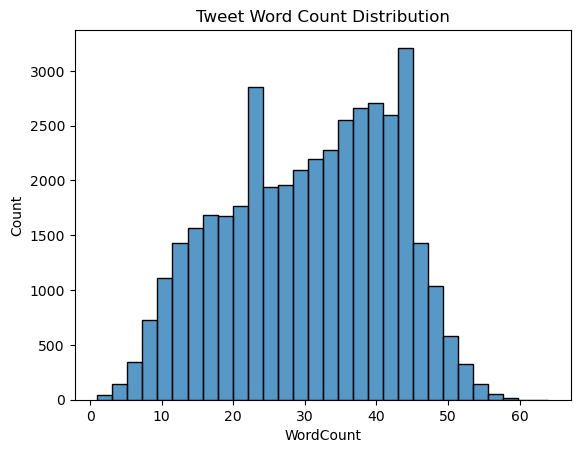

In [9]:
df['TweetLength'] = df['OriginalTweet'].apply(len)
df['WordCount'] = df['OriginalTweet'].apply(lambda x: len(x.split()))

sns.histplot(data=df, x='TweetLength', bins=30)
plt.title("Tweet Length Distribution")
plt.show()

sns.histplot(data=df, x='WordCount', bins=30)
plt.title("Tweet Word Count Distribution")
plt.show()

### Dates and Times

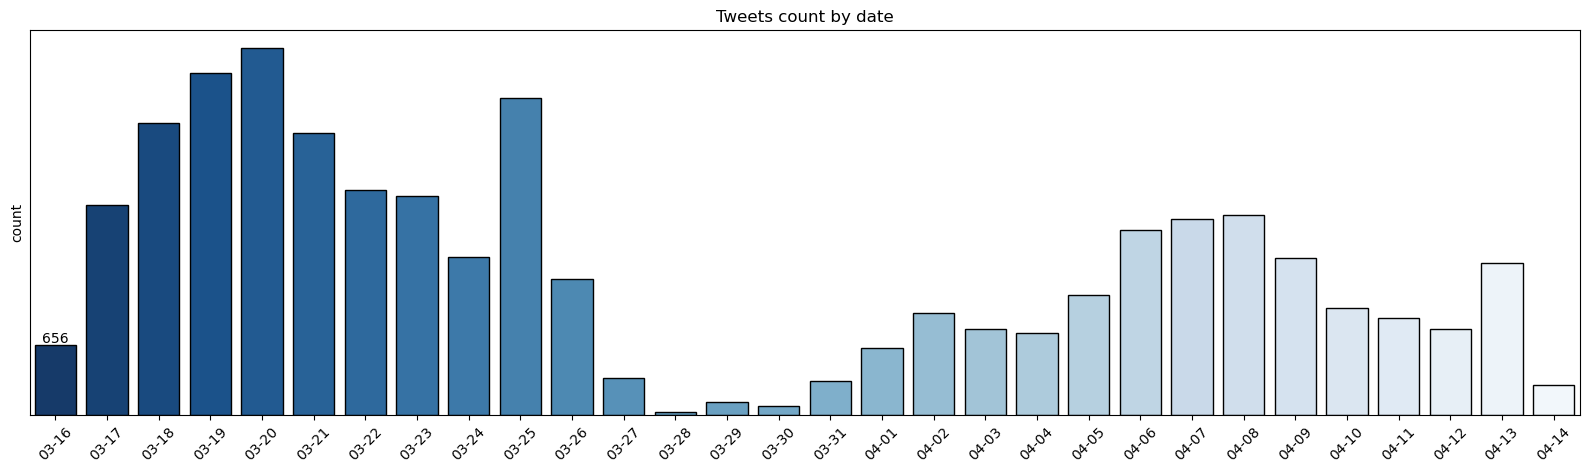

In [10]:
#convert time
df['TweetAt'] = pd.to_datetime(df['TweetAt'], dayfirst=True)
#of there are duplicats to drop them
df.drop_duplicates(subset='OriginalTweet',inplace=True)
df['TweetAt'] = pd.to_datetime(df['TweetAt'], dayfirst=True, errors='coerce')

tweets_per_day = (
    df['TweetAt'].dt.strftime('%m-%d')
    .value_counts()
    .sort_index()
    .reset_index()
)
tweets_per_day.columns = ['date', 'counts']

plt.figure(figsize=(20, 5))
ax = sns.barplot(
    x='date',
    y='counts',
    data=tweets_per_day,
    edgecolor='black',
    errorbar=None,
    palette='Blues_r'
)
plt.title('Tweets count by date')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.xticks(rotation=45)
plt.show()

**Tweet Activity and COVID-19 Infection Waves**

The tweet activity peaks on **March 20th** and **March 25th**, with a sharp decline afterward, followed by a rise again in **early April**, particularly around **April 5th-7th**.

This pattern could align with **COVID-19 infection spikes**, especially if these dates coincide with key developments like lockdown announcements, major outbreaks, or significant updates related to the pandemic.

In short, the tweet activity appears to reflect the **ups and downs of COVID-19 waves**, possibly driven by major events or news updates related to the virus.


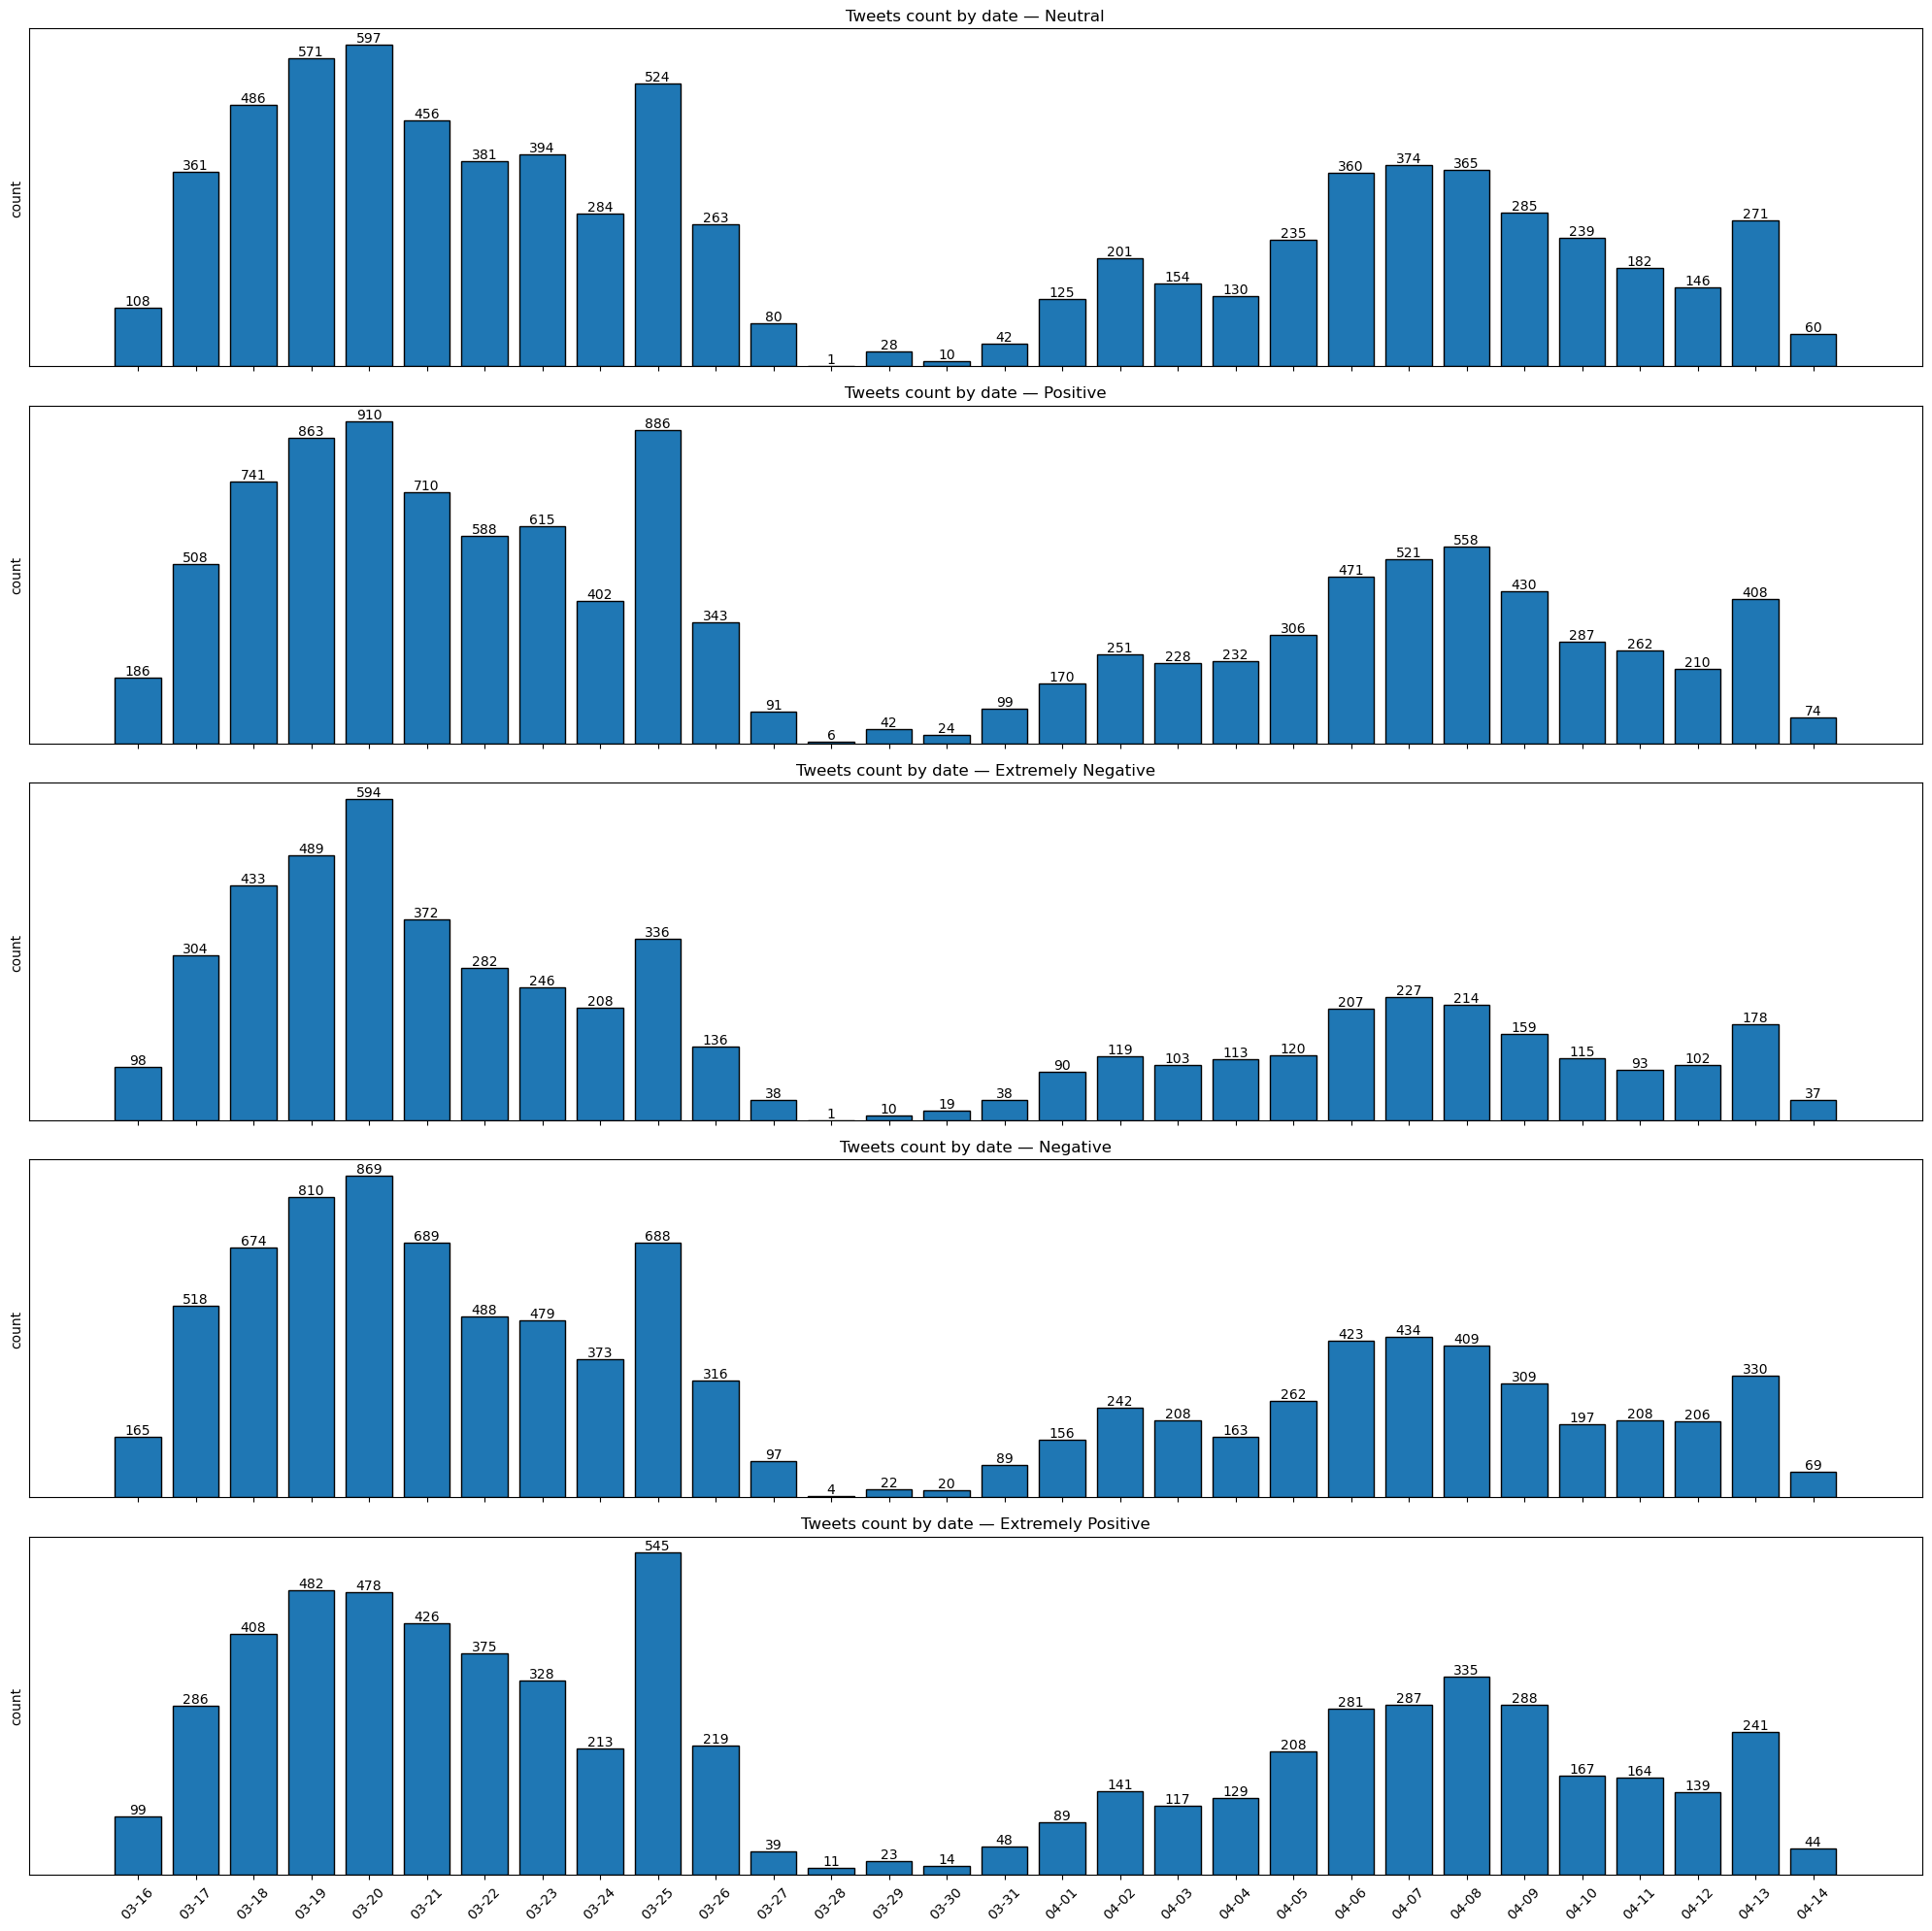

In [25]:
# --- ADD: per-Sentiment subplots ---

# Ensure rows have both date and sentiment
df = df.dropna(subset=['TweetAt', 'Sentiment'])

# Build day key and a stable chronological order (MM-DD)
df['day'] = df['TweetAt'].dt.strftime('%m-%d')
day_order = sorted(df['day'].unique(), key=lambda s: pd.to_datetime('2000-' + s))

# Counts per (Sentiment, day)
sentiments = df['Sentiment'].unique()
counts = (
    df.groupby(['Sentiment', 'day'])
      .size()
      .reset_index(name='counts')
)

# Fill missing (Sentiment, day) combinations with 0
full = pd.MultiIndex.from_product([sentiments, day_order], names=['Sentiment', 'day']).to_frame(index=False)
counts = full.merge(counts, on=['Sentiment', 'day'], how='left').fillna({'counts': 0})
counts['day'] = pd.Categorical(counts['day'], categories=day_order, ordered=True)

# Plot: one subplot per Sentiment
n = len(sentiments)
fig, axes = plt.subplots(nrows=n, figsize=(20, 4*n), sharex=True)
if n == 1:
    axes = [axes]

for ax, s in zip(axes, sentiments):
    d = counts[counts['Sentiment'] == s].sort_values('day')
    bars = ax.bar(d['day'], d['counts'], edgecolor='black')
    ax.set_title(f"Tweets count by date — {s}")
    ax.set_ylabel('count')
    ax.set_xlabel('')
    ax.set_yticks([])  # match original style: hide Y ticks
    ax.bar_label(bars)  # remove if Matplotlib < 3.4
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()
plt.show()

Across the period, all sentiment series show very similar temporal behavior (two waves with aligned peaks). Neutral consistently dominates, while Positive and Negative track each other closely; the Extremely ± classes are sparse and follow the same pattern. There is no clear time lag or regime shift between sentiments—differences are minor and mostly proportional. The sharp late-March dip appears dataset-driven (e.g., sampling/drop_duplicates) rather than a real behavioral change. Overall, no material difference in dynamics between sentiments

Text(0.5, 1.0, 'Tweets Heatmap by Hour and Weekday')

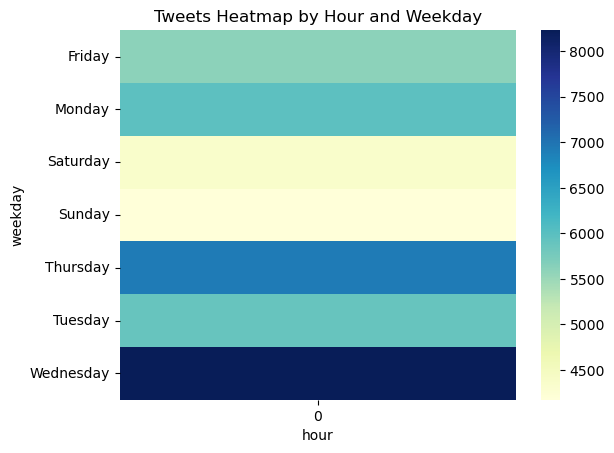

In [59]:
df['weekday'] = df['TweetAt'].dt.day_name()
df['hour'] = df['TweetAt'].dt.hour
pivot = df.pivot_table(index='weekday', columns='hour', values='TweetAt', aggfunc='count')
sns.heatmap(pivot, cmap='YlGnBu')
plt.title('Tweets Heatmap by Hour and Weekday')

### Locations

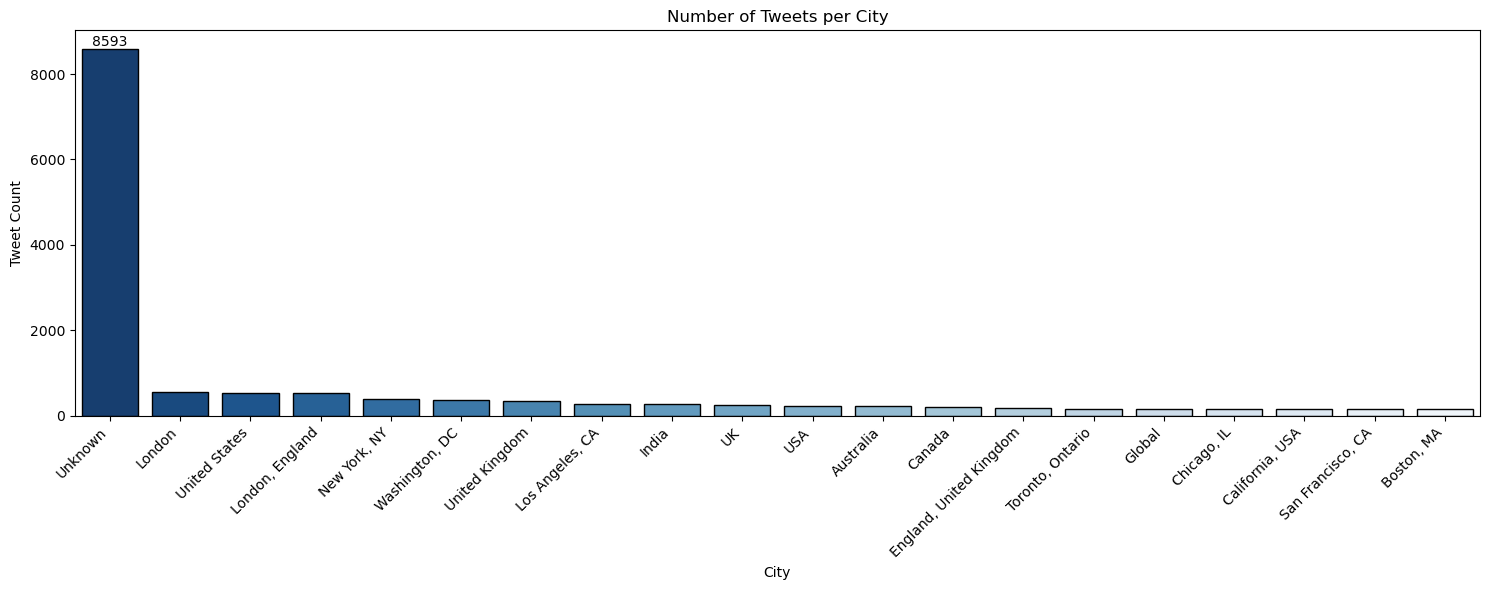

In [3]:
# Fill missing data
df['Location'] = df['Location'].fillna('Unknown').str.strip()

# Count tweets in every location
tweets_per_city = df['Location'].value_counts().reset_index()
tweets_per_city.columns = ['city', 'count']

# Take top 20 cities for visualization
top_cities = tweets_per_city.sort_values('count', ascending=False).head(20)

# Plot
plt.figure(figsize=(15, 6))
ax = sns.barplot(
    x='city',
    y='count',
    data=top_cities,
    edgecolor='black',
    palette='Blues_r'
)
plt.title('Number of Tweets per City')
plt.ylabel('Tweet Count')
plt.xlabel('City')
plt.xticks(rotation=45, ha='right')
ax.bar_label(ax.containers[0])
plt.tight_layout()
plt.show()

**Insights from Number of Tweets per City**

The graph showing the number of tweets per city is **difficult to interpret** due to its **disorganized nature**. The distribution of tweets across various cities is **highly skewed**, with the overwhelming majority labeled as **"Unknown"**, which dominates the graph. This makes it hard to draw meaningful insights from the data.

Additionally, the labels for the cities are not well-organized, and cities like **London**, **New York**, and **Los Angeles** are grouped in different formats (e.g., "London, England" vs. "London" or "New York, NY"), which makes it harder to interpret the data accurately.


**"The locations_with_country.xlsx" file was generated with the assistance of ChatGPT. We provided a list of distinct locations to ChatGPT, which then returned this file, assigning the correct country to each location.**

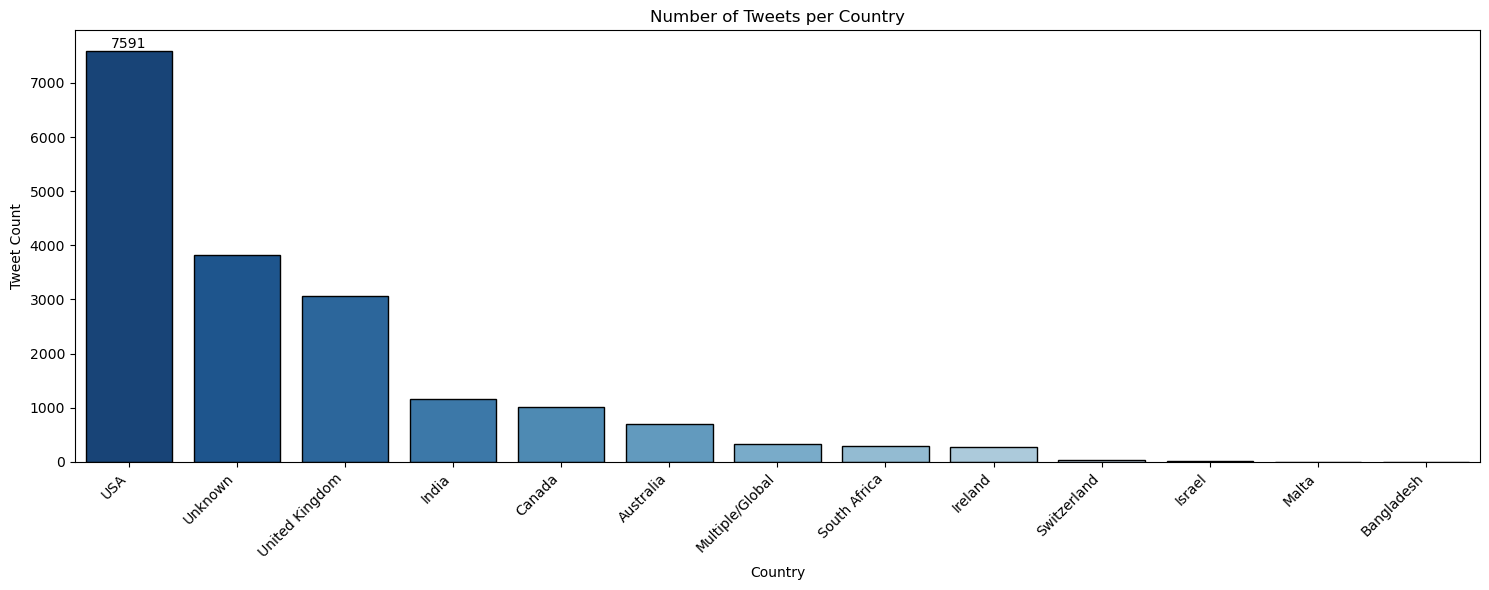

In [6]:
# 1) Load the mapping file I generated (unique Location → Country)
map_df = pd.read_excel("locations_with_country.xlsx", usecols=["Location", "Country"])

# 2) Create a normalized key for robust matching (trim + lowercase)
map_df["Location_key"] = map_df["Location"].astype(str).str.strip().str.lower()
df["Location_key"] = df["Location"].astype(str).str.strip().str.lower()

# 3) Merge the mapping into your DF on the normalized key
df = df.merge(
    map_df[["Location_key", "Country"]].rename(columns={"Country": "Country_map"}),
    on="Location_key",
    how="left"
)

# 4) If you already have a 'Country' column, keep existing values and fill only missing ones.
#    Otherwise, create it from the mapping.
if "Country" in df.columns:
    df["Country"] = df["Country"].fillna(df["Country_map"])
else:
    df["Country"] = df["Country_map"]

# 5) Drop helper columns
df.drop(columns=["Location_key", "Country_map"], inplace=True)

# --- Build the plot data (Top 20 countries by tweet count) ---
tweets_per_country = df["Country"].value_counts().reset_index()
tweets_per_country.columns = ["Country", "count"]
top_countries = tweets_per_country.sort_values("count", ascending=False).head(20)

# --- Plot: Number of Tweets per Country ---
plt.figure(figsize=(15, 6))
ax = sns.barplot(
    x="Country",
    y="count",
    data=top_countries,
    edgecolor="black",
    palette="Blues_r"  # color palette; remove or change if needed
)
plt.title("Number of Tweets per Country")
plt.ylabel("Tweet Count")
plt.xlabel("Country")
plt.xticks(rotation=45, ha="right")  # rotate x labels for readability
ax.bar_label(ax.containers[0])       # add value labels on bars
plt.tight_layout()
plt.show()

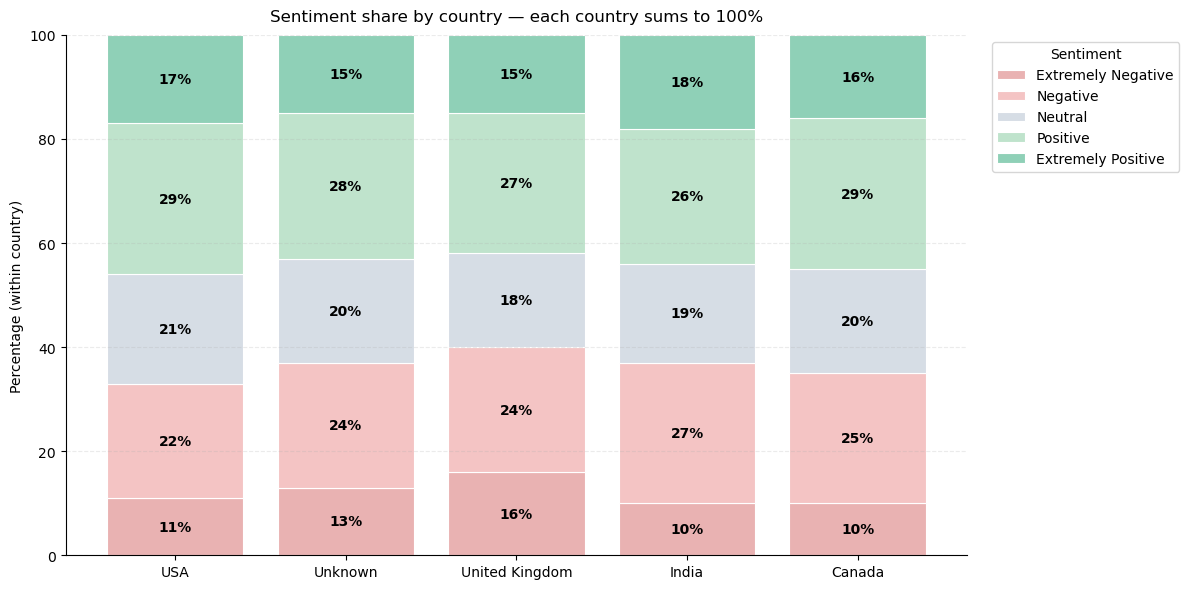

In [22]:
TOP_N = 5                           # number of top countries to plot
LABEL_MIN_PERCENT = 5               # do not place a label if the segment is smaller than 5%
TITLE = 'Sentiment share by country — each country sums to 100%'

# Soft, pleasant colors (negative → reddish, positive → greenish, neutral → gray-blue)
PALETTE = {
    "Extremely Negative": "#e9b2b2",
    "Negative":            "#f4c4c4",
    "Neutral":             "#d6dde5",
    "Positive":            "#bfe3cc",
    "Extremely Positive":  "#8fd0b7",
}
DEFAULT_COLOR = "#cfcfcf"  # fallback for unexpected sentiment labels

# ==========================
# Data preparation
# Assumes df has columns: 'Country', 'Sentiment'
# ==========================
df_clean = df.dropna(subset=['Country', 'Sentiment']).copy()
df_clean['Country'] = df_clean['Country'].astype(str).str.strip()
df_clean['Sentiment'] = df_clean['Sentiment'].astype(str).str.strip()

# Pick top-N countries by tweet volume
top_countries = df_clean['Country'].value_counts().nlargest(TOP_N).index.tolist()
subset = df_clean[df_clean['Country'].isin(top_countries)].copy()

# Stable sentiment order (adjust to your labels if needed)
canonical = ["Extremely Negative", "Negative", "Neutral", "Positive", "Extremely Positive"]
observed = subset['Sentiment'].unique().tolist()
sentiments = [s for s in canonical if s in observed] or subset['Sentiment'].value_counts().index.tolist()

subset['Country'] = pd.Categorical(subset['Country'], categories=top_countries, ordered=True)
subset['Sentiment'] = pd.Categorical(subset['Sentiment'], categories=sentiments, ordered=True)

# Count table and within-country percentages (row-normalized → each country sums to 100)
counts = pd.crosstab(subset['Country'], subset['Sentiment']).reindex(
    index=top_countries, columns=sentiments, fill_value=0
)
pct = counts.div(counts.sum(axis=1).replace(0, np.nan), axis=0) * 100.0
pct = pct.fillna(0.0)  # handle any fully-empty rows defensively

# Round with the "largest remainder" method to make each row sum EXACTLY 100 after rounding
def round_row_to_100(row, decimals=0):
    """
    Round a percentage row so the sum is exactly 100 using the largest remainder method.
    Suitable for labeling; preserves total exactly after rounding.
    """
    scale = 10 ** decimals
    scaled = row * scale
    floors = np.floor(scaled).astype(int)
    remainder = int(100 * scale - floors.sum())
    frac = (scaled - floors).to_numpy()
    order = np.argsort(-frac)  # indices sorted by largest fractional parts
    result = floors.to_numpy()
    i = 0
    while remainder > 0 and i < len(order):
        result[order[i]] += 1
        remainder -= 1
        i += 1
    return pd.Series(result / scale, index=row.index)

pct_rounded = pct.apply(round_row_to_100, axis=1, decimals=0)
assert (pct_rounded.sum(axis=1) == 100).all(), "Row percentages must sum to 100."

# ==========================
# Plot (matplotlib only)
# ==========================
plt.figure(figsize=(12, 6))
ax = plt.gca()

# Clean look and light grid
ax.set_ylim(0, 100)
ax.yaxis.grid(True, linestyle='--', alpha=0.25)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

x = np.arange(len(top_countries))
bottom = np.zeros(len(top_countries), dtype=float)

def text_color_for_bg(hex_color):
    """
    Choose black/white text color based on background luminance for readability.
    """
    hc = hex_color.lstrip('#')
    r = int(hc[0:2], 16) / 255.0
    g = int(hc[2:4], 16) / 255.0
    b = int(hc[4:6], 16) / 255.0
    luminance = 0.299 * r + 0.587 * g + 0.114 * b  # ITU-R BT.601
    if luminance < 0.45:
        return 'white'
    if luminance > 0.75:
        return 'black'
    return 'black'

# Draw 100% stacked bars
for s in sentiments:
    vals = pct_rounded[s].to_numpy()
    color = PALETTE.get(s, DEFAULT_COLOR)
    bars = ax.bar(x, vals, bottom=bottom, edgecolor='white', linewidth=0.8, label=s, color=color)
    # In-segment labels
    for xi, v, b in zip(x, vals, bottom):
        if v >= LABEL_MIN_PERCENT:
            ax.text(
                xi, b + v / 2, f"{int(v)}%",
                ha='center', va='center',
                fontsize=10, fontweight='bold',
                color=text_color_for_bg(color)
            )
    bottom += vals

ax.set_xticks(x)
ax.set_xticklabels(top_countries, rotation=0)
ax.set_ylabel('Percentage (within country)')
ax.set_title(TITLE, pad=10)
ax.legend(title='Sentiment', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


The sentiment split looks broadly similar across countries—no country shows a strong unique skew.

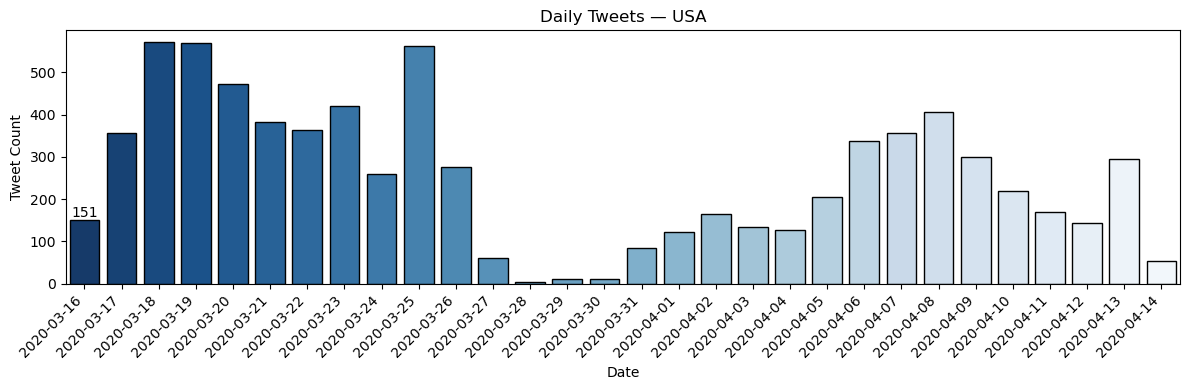

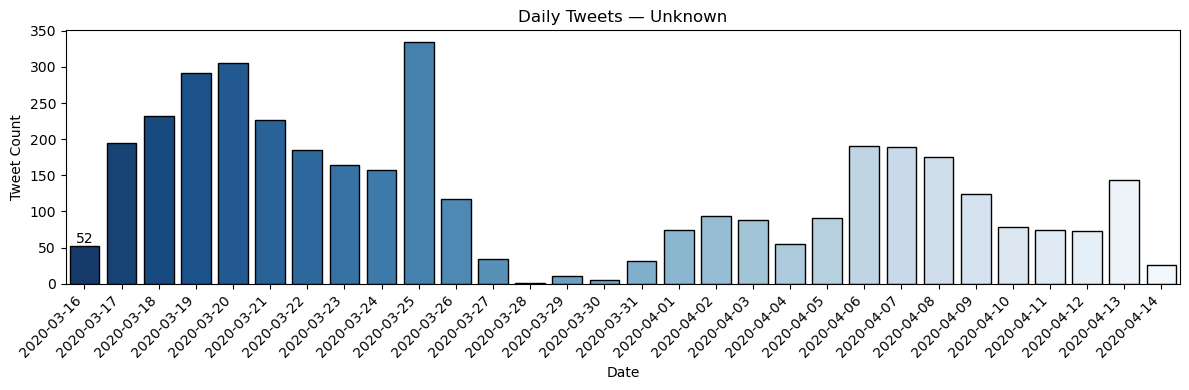

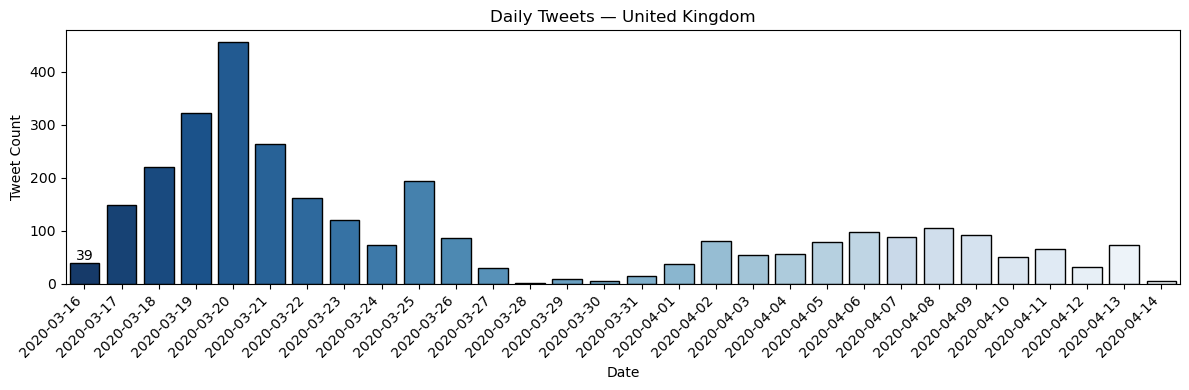

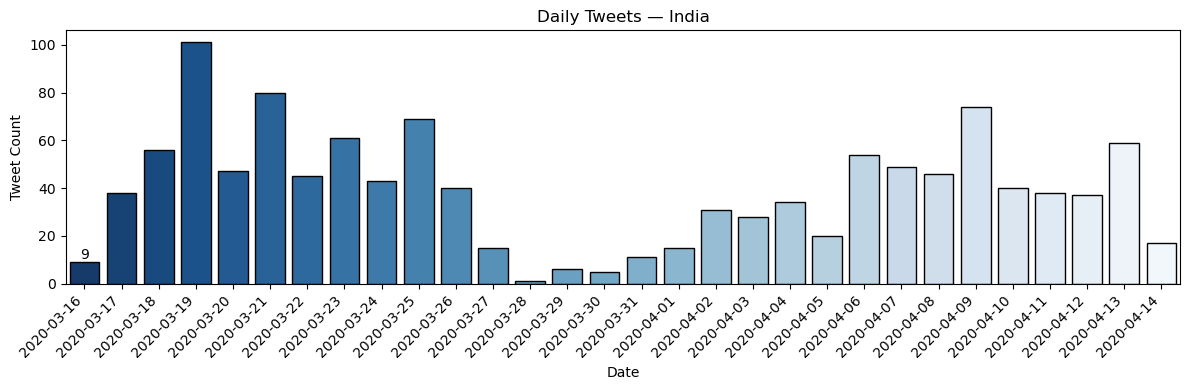

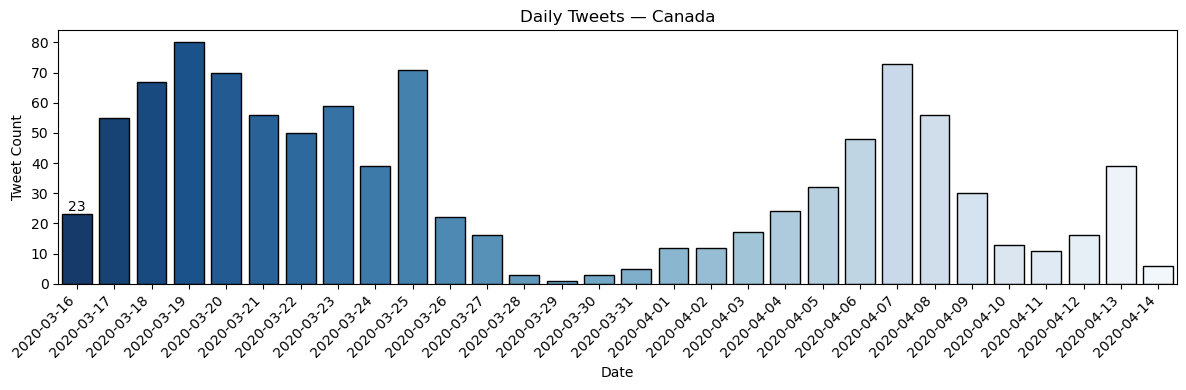

In [24]:
# --- Ensure datetime and subset to those countries ---
df['TweetAt'] = pd.to_datetime(df['TweetAt'], errors='coerce', dayfirst=True)
subset = df[df['Country'].isin(top_countries) & df['TweetAt'].notna()].copy()

# --- Aggregate: daily tweet counts per country ---
subset['date'] = subset['TweetAt'].dt.normalize()  # keep date (no time)
daily_counts = (
    subset.groupby(['Country', 'date'])
          .size()
          .reset_index(name='count')
)

# --- Plot a separate bar chart for each country ---

for c in top_countries:
    d = daily_counts[daily_counts['Country'] == c].sort_values('date').copy()
    d['date_str'] = d['date'].dt.strftime('%Y-%m-%d')  # use strings for discrete x-axis

    plt.figure(figsize=(12, 4))
    ax = sns.barplot(
        data=d,
        x='date_str',
        y='count',
        edgecolor='black',
        errorbar=None,
        palette='Blues_r'
    )
    ax.set_title(f'Daily Tweets — {c}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Tweet Count')
    plt.xticks(rotation=45, ha='right')

    # Add value labels on bars (only if bars exist)
    if ax.containers:
        ax.bar_label(ax.containers[0])

    plt.tight_layout()
    plt.show()

In [12]:
# ----- Focus on top-5 countries -----
top_countries = df['Country'].value_counts().nlargest(5).index.tolist()
sub = df[df['Country'].isin(top_countries)].copy()
sub['TweetAt'] = pd.to_datetime(sub['TweetAt'], errors='coerce', dayfirst=True)
sub = sub.dropna(subset=['Country', 'Sentiment', 'TweetAt'])

# =========================
# 1) SENTIMENT differences
# Chi-square + Cramer's V + standardized residuals (with/without "Unknown")
# =========================
def chi2_summary(frame, label="ALL"):
    # Contingency table: Country x Sentiment
    ct = pd.crosstab(frame['Country'], frame['Sentiment'])
    chi2, p, dof, exp = stats.chi2_contingency(ct)
    n = ct.to_numpy().sum()
    r, c = ct.shape
    cramers_v = np.sqrt(chi2 / (n * (min(r-1, c-1))))
    resid = (ct - exp) / np.sqrt(exp)  # standardized residuals

    print(f"\n[Sentiment ~ Country] ({label})")
    print(f"Chi-square={chi2:.2f}, dof={dof}, p-value={p:.3g}, Cramer's V={cramers_v:.3f}")
    print("Effect size guide: ~0.10 small, ~0.30 medium, ~0.50 large")
    print("\nTop cells driving the difference (|residual|):")
    print(resid.stack().abs().sort_values(ascending=False).head(10))

    return ct, resid, cramers_v, p

# With 'Unknown'
ct_all, resid_all, v_all, p_all = chi2_summary(sub, label="with UNKNOWN")

# Without 'Unknown' (often cleaner)
sub_no_unk = sub[sub['Country'] != 'Unknown']
ct_nu, resid_nu, v_nu, p_nu = chi2_summary(sub_no_unk, label="NO UNKNOWN")

# ----- Optional: pairwise two-proportion z-tests per sentiment (Holm correction) -----
def pairwise_prop_tests(ct, sentiment):
    rows = []
    for a, b in combinations(ct.index, 2):
        n1, x1 = ct.loc[a].sum(), ct.loc[a, sentiment]
        n2, x2 = ct.loc[b].sum(), ct.loc[b, sentiment]
        p_pool = (x1 + x2) / (n1 + n2)
        se = np.sqrt(p_pool * (p_pool - 1) * (1/n1 + 1/n2) * -1)  # same as p_pool*(1-p_pool)
        z = (x1/n1 - x2/n2) / se if se > 0 else np.nan
        pval = 2 * stats.norm.sf(abs(z)) if np.isfinite(z) else np.nan
        rows.append({"A": a, "B": b, "sentiment": sentiment, "z": z, "p": pval})
    out = pd.DataFrame(rows).sort_values("p")
    # Holm–Bonferroni
    m = len(out)
    out["p_holm"] = [min((m - i) * p, 1.0) for i, p in enumerate(out["p"].values)]
    return out

# Example: which countries differ in Positive proportion?
# pairwise_pos = pairwise_prop_tests(ct_nu, sentiment="Positive")
# pairwise_pos.head(10)

# =========================
# 2) TIME-SERIES shape differences
# Correlation of z-scored daily counts per country (shape, not scale)
# =========================
daily = (
    sub.groupby(['Country', sub['TweetAt'].dt.normalize()])
       .size()
       .unstack(0)
       .reindex(columns=top_countries)   # keep order
       .fillna(0)
)

# Z-score within each country to compare shapes (remove scale)
Z = (daily - daily.mean()) / daily.std(ddof=0).replace(0, np.nan)
corr = Z.corr()

print("\n[Daily shape similarity] Pearson correlation of z-scored daily counts:")
print(corr)

print("\nSummary of pairwise correlations:")
upper = corr.where(np.triu(np.ones_like(corr, dtype=bool), k=1)).stack()
print(f"median r = {upper.median():.2f}, min r = {upper.min():.2f}, max r = {upper.max():.2f}")

# =========================
# Quick practical rule-of-thumb:
# - If Cramer's V <~ 0.10: differences in sentiment are small in practice.
# - If median r of Z-series >~ 0.7: daily dynamics are very similar across countries.
# =========================



[Sentiment ~ Country] (with UNKNOWN)
Chi-square=90.94, dof=16, p-value=1.68e-12, Cramer's V=0.037
Effect size guide: ~0.10 small, ~0.30 medium, ~0.50 large

Top cells driving the difference (|residual|):
Country         Sentiment         
United Kingdom  Extremely Negative    5.607827
USA             Extremely Negative    2.912910
Unknown         Extremely Positive    2.595247
United Kingdom  Neutral               2.543896
USA             Negative              2.308461
                Extremely Positive    2.220437
India           Negative              1.981727
                Extremely Negative    1.913173
Canada          Extremely Negative    1.829274
USA             Neutral               1.714627
dtype: float64

[Sentiment ~ Country] (NO UNKNOWN)
Chi-square=80.09, dof=12, p-value=3.97e-12, Cramer's V=0.046
Effect size guide: ~0.10 small, ~0.30 medium, ~0.50 large

Top cells driving the difference (|residual|):
Country         Sentiment         
United Kingdom  Extremely Negative   

Sentiment × Country: Statistically significant but practically negligible differences. Cramér’s V ≈ 0.037–0.046 (well below 0.10 “small”).

Daily dynamics: Strongly synchronized across countries; z-scored daily counts show median r = 0.84 (range 0.68–0.96).

Minor pockets: Slight deviations (e.g., UK in Extremely Negative, USA in Negative/Extremely Negative, Unknown in Extremely Positive, India in Negative)—localized, not pattern-changing.

Bottom line: No material difference in behavior across countries.

### Hashtags

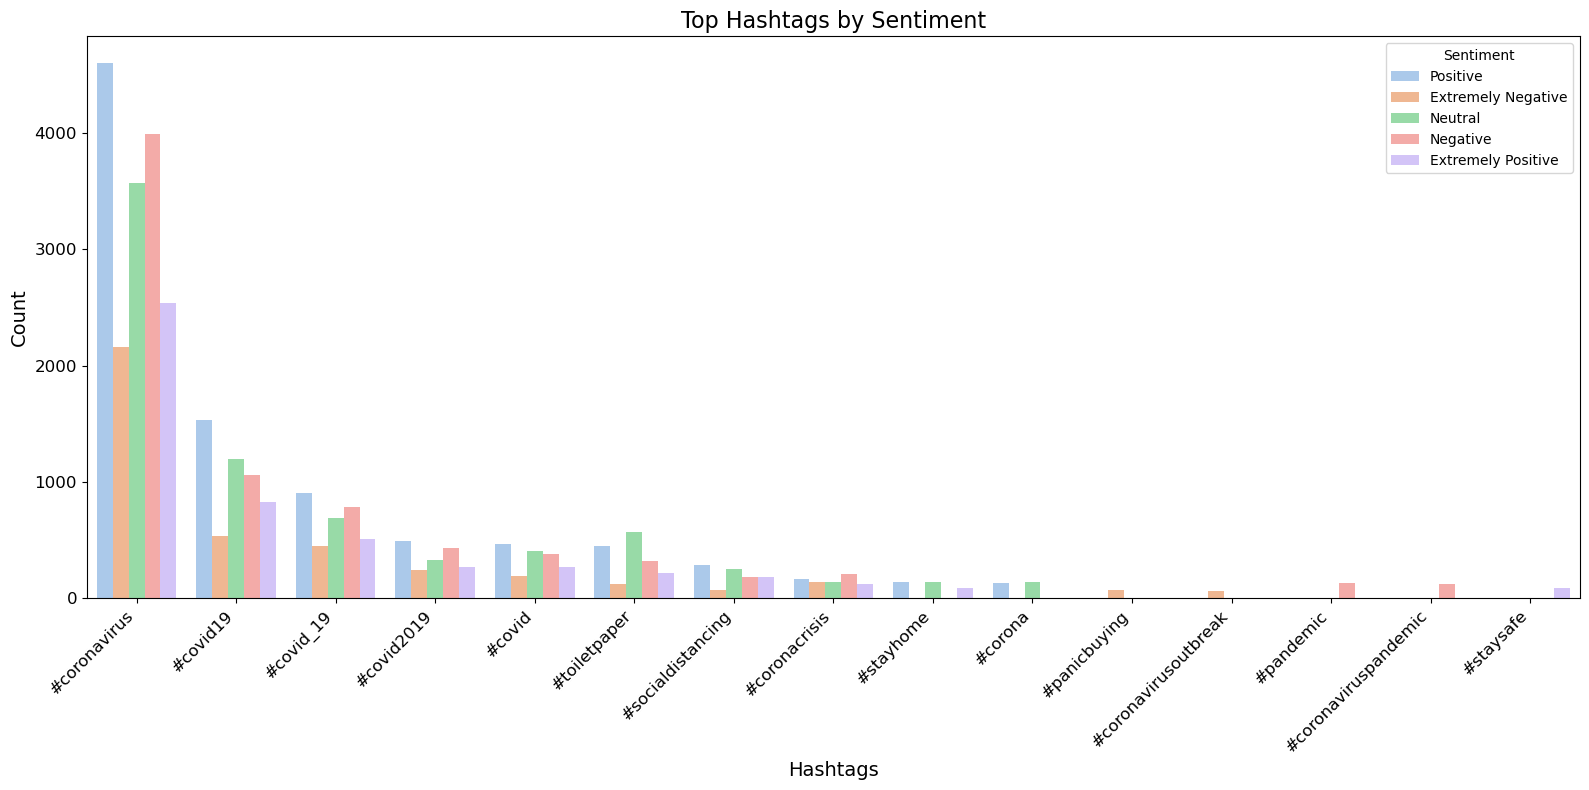

In [71]:
# --- Extract original hashtags from tweet text (before cleaning) ---
def extract_hashtags(text):
    # Returns a list of hashtags (lowercased), e.g., ["#covid19", "#stayhome"]
    return re.findall(r"#\w+", str(text).lower())

# --- Add a 'hashtags' column ---
df['hashtags'] = df['OriginalTweet'].apply(extract_hashtags)

# --- Keep only tweets that contain at least one hashtag ---
df_hashtags = df[df['hashtags'].str.len() > 0].copy()

# --- Build a table of top-N hashtags per sentiment ---
def top_hashtags_by_sentiment(df_in, top_n=10):
    """
    For each sentiment, count hashtags and return the top 'top_n' most common.
    Output format: dict[sentiment] = list of (hashtag, count).
    """
    sentiment_hashtag_counts = {}
    for sentiment in df_in['Sentiment'].unique():
        # Flatten list of lists of hashtags for this sentiment
        hashtags = sum(df_in[df_in['Sentiment'] == sentiment]['hashtags'], [])
        most_common = Counter(hashtags).most_common(top_n)
        sentiment_hashtag_counts[sentiment] = most_common
    return sentiment_hashtag_counts

# --- Compute results ---
top_n = 10
hashtag_data = top_hashtags_by_sentiment(df_hashtags, top_n=top_n)

# --- Convert to a DataFrame for plotting ---
rows = []
for sentiment, tags in hashtag_data.items():
    for tag, count in tags:
        rows.append({'Sentiment': sentiment, 'Hashtag': tag, 'Count': count})
df_plot = pd.DataFrame(rows)

# --- Plot: Top hashtags by sentiment ---
plt.figure(figsize=(16, 8))
sns.barplot(
    data=df_plot,
    x='Hashtag', y='Count', hue='Sentiment',
    palette='pastel'  # soft color palette
)
plt.title("Top Hashtags by Sentiment", fontsize=16)
plt.xlabel("Hashtags", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

**Should Hashtags Be Included in Sentiment Analysis?**

Pros of Keeping Hashtags:
- **Emotional Indicators**: Hashtags often carry emotional context (e.g., `#staystrong`, `#panicbuying`).
- **Contextual Meaning**: They help clarify the topic, especially in short posts like tweets.
- **Real-World Relevance**: Users commonly express emotions and themes through hashtags.

Cons of Keeping Hashtags:
- **Noise**: Generic hashtags (e.g., `#covid19`) might not add meaningful sentiment.
- **Sentiment Bias**: Overused hashtags could skew the analysis.
- **Processing Issues**: Compound hashtags (e.g., `#thankyouhealthcareworkers`) might be tricky to analyze without breaking them down.

What to Do:
- **Keep hashtags**, but process them wisely:
  - Split compound hashtags (e.g., `#StayHome` → `stay home`).
  - Remove or give less weight to overly broad tags.
  - You can also treat hashtags as separate features in your model.

In short, **smart handling of hashtags** can improve sentiment analysis instead of getting in the way.


### Other Analysis

In [ ]:
sentiment_map = {
    'Extremely Negative': -2,
    'Negative': -1,
    'Neutral': 0,
    'Positive': 1,
    'Extremely Positive': 2
}

df['SentimentOrdinal'] = df['Sentiment'].map(sentiment_map)

correlation_by_length = df['TweetLength'].corr(df['SentimentOrdinal'])
print(f"Correlation between Tweet Length and Sentiment (ordinal): {correlation_by_length:.4f}")

correlation_by_word = df['WordCount'].corr(df['SentimentOrdinal'])
print(f"Correlation between word count and Sentiment (ordinal): {correlation_by_word:.4f}")

**Correlation between Tweet Length, Word Count, and Sentiment**

We tested the correlation between tweet length, word count, and sentiment (ordinal scale). The results are as follows:

- **Tweet Length and Sentiment**: Correlation = **0.0461** (weak positive relationship).
- **Word Count and Sentiment**: Correlation = **0.0283** (extremely weak positive relationship).

**Conclusion:**
There is **no significant correlation** between tweet length, word count, and sentiment. Both correlations are very low, indicating that sentiment is not strongly influenced by these factors.

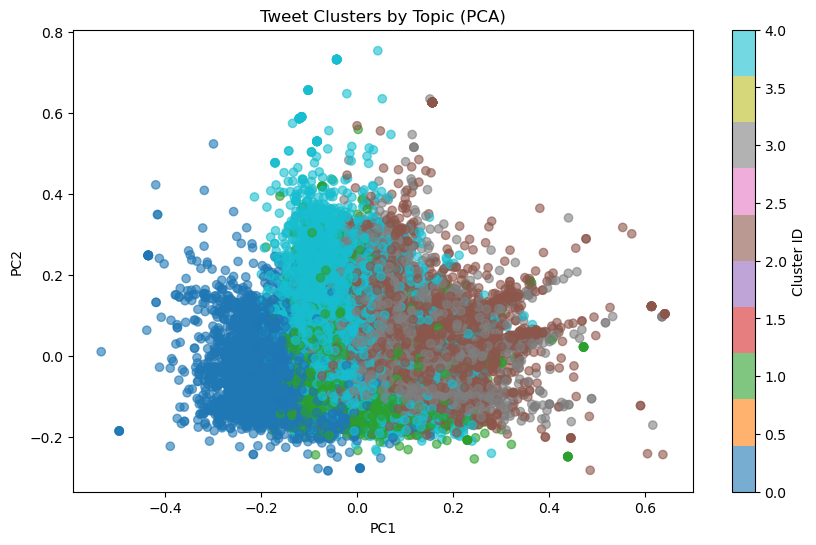

In [100]:
# Vectorize tweets
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df['OriginalTweet'].dropna())

# Cluster
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='tab10', alpha=0.6)
plt.title("Tweet Clusters by Topic (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster ID')
plt.show()

**Clustering Attempt with TF-IDF**

We attempted to perform clustering using **TF-IDF** to group the tweets into meaningful topics. However, the results do not appear to be very useful for further analysis, as the clusters do not show clear or distinct groupings that could help us in understanding the data.

The plot suggests some separation of points, but the clusters are not well-defined, and they overlap significantly, making it difficult to draw meaningful conclusions from them.

## Key Findings

1. **Temporal patterns** — similar shapes across sentiments; no sentiment-specific regime shifts.
2. **Class imbalance (project constraint)** — the dataset is imbalanced. Per project rules we **will not** rebalance (no resampling/weights). Therefore, we will use **F1-macro** as the primary metric (since accuracy is misleading) and keep **stratified** train/val/test splits.
3. **Hashtags** — dominated by generic tags (e.g., `#covid19`) with some sentiment-specific tags; promising as features.
4. **Geography** — weak association with sentiment (low Cramér’s V); coarse geo likely adds limited standalone lift.
5. **Text statistics** — minor length differences across sentiments; length alone is a weak predictor.
6. **Data hygiene** — encoding glitches and ambiguous free-text locations were identified and mitigated; retained examples to illustrate pitfalls.

## Clean Data

In [86]:
nltk.download('punkt')  # נדרש לפונקציות אחרות, לא חובה כאן

nlp = spacy.load("en_core_web_sm")

def strip_emoji(text):
    return emoji.replace_emoji(text, replace='')

def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower()
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    banned_list = string.punctuation + 'Ã±ã¼â»§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

def clean_hashtags(tweet):
    # Split compound hashtags into individual words
    tweet = re.sub(r'#(\w+)', r' \1', tweet)  # Convert #hashtag to 'hashtag'
    tweet = re.sub(r'_', ' ', tweet)  # Replace underscores with spaces
    return tweet

def filter_chars(a):
    return ' '.join(['' if ('$' in word or '&' in word) else word for word in a.split(' ')])

def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text).strip()

def basic_clean_text(text):
    text = strip_emoji(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    return text

def clean_text_lemmatize(text):
    doc = nlp(text)
    lemmas = [
        token.lemma_.lower() 
        for token in doc 
        if token.is_alpha and not token.is_stop
    ]
    return ' '.join(lemmas)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amith\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [87]:
# --- ניקוי בפועל על הדאטה ---
df['cleaned_tweets'] = df['OriginalTweet'].astype(str).apply(basic_clean_text)
df['cleaned_tweets'] = df['cleaned_tweets'].apply(clean_text_lemmatize)

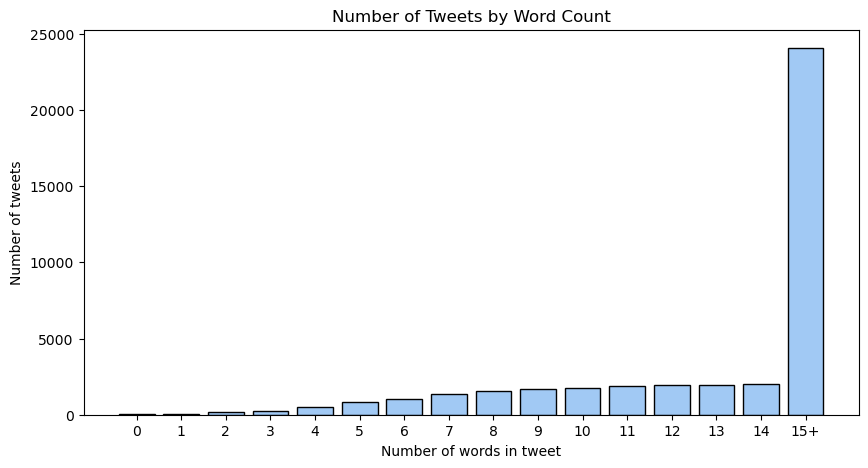

Tweets before filtering: 41157
Tweets after filtering (>=5 words): 40126


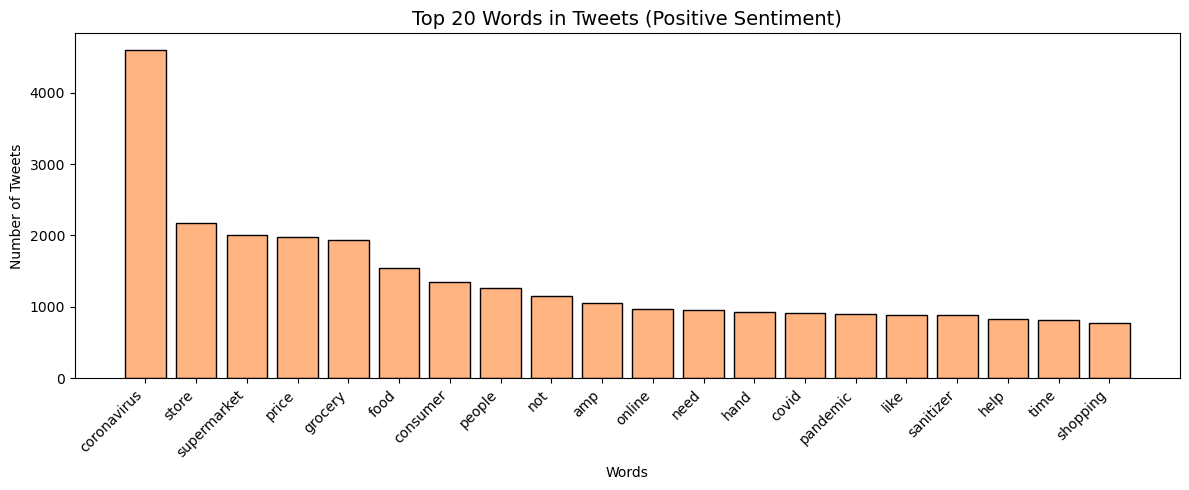

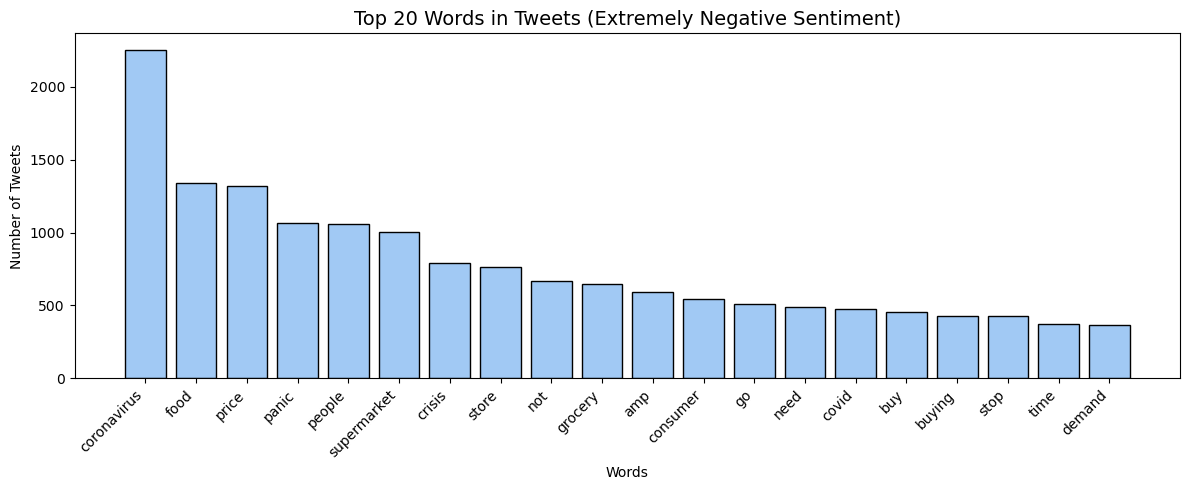

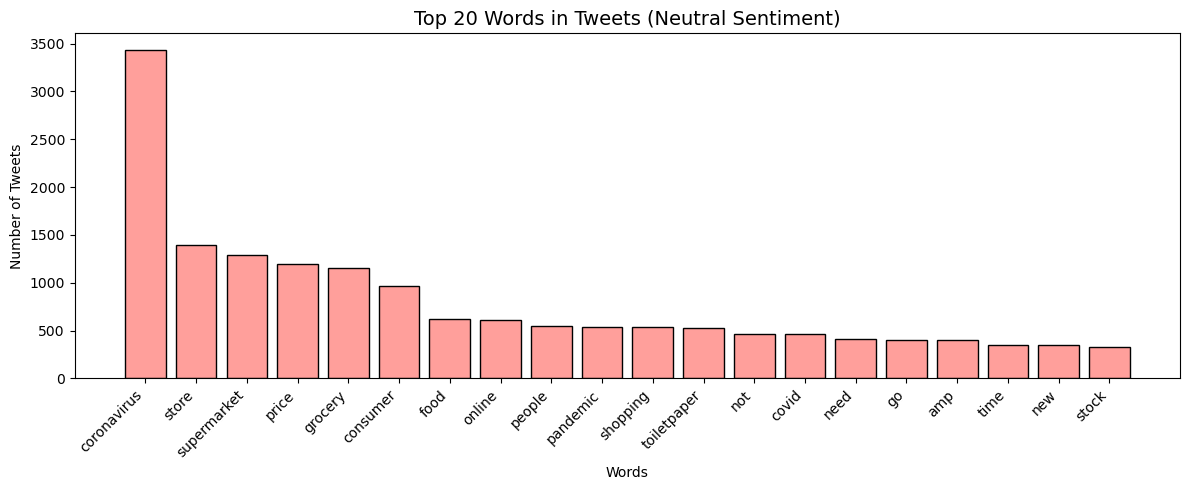

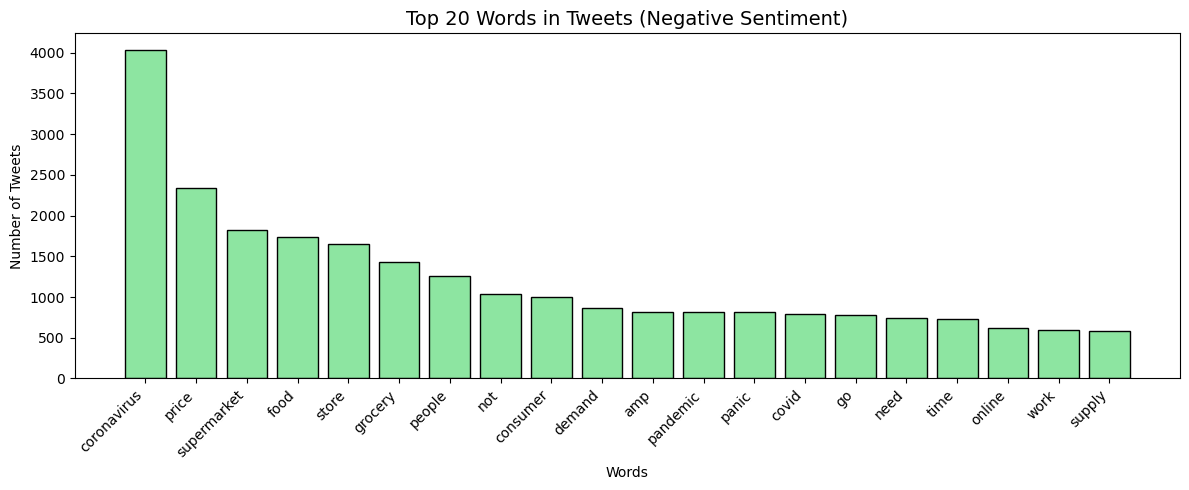

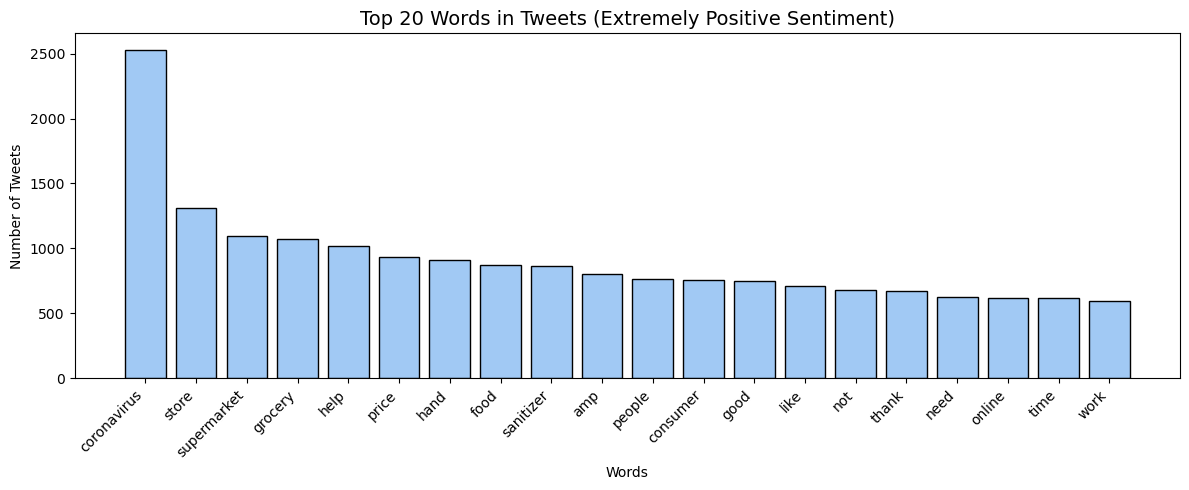

In [112]:
# --- גרף התפלגות מפורט של מספר מילים ---
def count_words(text):
    return len(text.split())

df['word_count'] = df['cleaned_tweets'].apply(count_words)
max_words = 15  # ניתן לשנות לפי הצורך

word_counts = df['word_count'].value_counts().sort_index()

# ודא שכל הערכים מ-0 ועד max_words קיימים ב-series
for i in range(max_words + 1):
    if i not in word_counts:
        word_counts[i] = 0

word_counts = word_counts.sort_index()

# אגד את כל הטוויטים עם מילים >= max_words לקטגוריה אחת
word_counts_plot = word_counts.loc[:max_words - 1].copy()
word_counts_plot[max_words] = word_counts.loc[max_words:].sum()

labels = [str(i) for i in range(max_words)]
labels.append(f'{max_words}+')

plt.figure(figsize=(10,5))
plt.bar(labels, word_counts_plot.values, color=sns.color_palette("pastel")[0], edgecolor='black')  # צבע פסטל
plt.title('Number of Tweets by Word Count')
plt.xlabel('Number of words in tweet')
plt.ylabel('Number of tweets')
plt.show()

# --- סינון ציוצים עם פחות מ-5 מילים ---

df_filtered = df[df['word_count'] >= 5].copy()

print(f"Tweets before filtering: {len(df)}")
print(f"Tweets after filtering (>=5 words): {len(df_filtered)}")

df = df_filtered

df['word_count'] = df['cleaned_tweets'].apply(lambda x: len(x.split()))

# --- הגדרת צבעים לפי סנטימנט ---
sentiment_colors = {
    'Positive': sns.color_palette("pastel")[1],  # צבע פסטל ל-POSITIVE
    'Negative': sns.color_palette("pastel")[2],  # צבע פסטל ל-NEGATIVE
    'Neutral': sns.color_palette("pastel")[3]    # צבע פסטל ל-NEUTRAL
}

# --- פונקציית ספירה: בכמה טוויטים כל מילה מופיעה ---
def compute_top_words_by_tweet_count(df_sentiment, top_n=20):
    word_tweet_count = defaultdict(int)
    for tweet in df_sentiment['cleaned_tweets']:
        words = set(word for word in tweet.split() if len(word) > 1)  # הוספתי את התנאי כאן
        for word in words:
            word_tweet_count[word] += 1
    return pd.DataFrame(Counter(word_tweet_count).most_common(top_n), columns=['word', 'tweet_count'])

# --- ציור גרפים לפי סנטימנט ---
sentiments = df_filtered['Sentiment'].unique()

for sentiment in sentiments:
    df_sent = df_filtered[df_filtered['Sentiment'] == sentiment]
    top_words_df = compute_top_words_by_tweet_count(df_sent)

    plt.figure(figsize=(12, 5))
    color = sentiment_colors.get(sentiment, sns.color_palette("pastel")[0])  # שימוש בצבע פסטל

    plt.bar(top_words_df['word'], top_words_df['tweet_count'], color=color, edgecolor='black')
    plt.title(f"Top 20 Words in Tweets ({sentiment} Sentiment)", fontsize=14)
    plt.ylabel('Number of Tweets')
    plt.xlabel('Words')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [114]:
df.to_csv("Corona_NLP_train_clean.csv", encoding='ISO-8859-1')
# clean test data and save
df_test['cleaned_tweets'] = df_test['OriginalTweet'].astype(str).apply(basic_clean_text)
df_test['cleaned_tweets'] = df_test['cleaned_tweets'].apply(clean_text_lemmatize)
df_test.to_csv("Corona_NLP_test_clean.csv", encoding='ISO-8859-1')

**Basic Statistic After Cleaning**

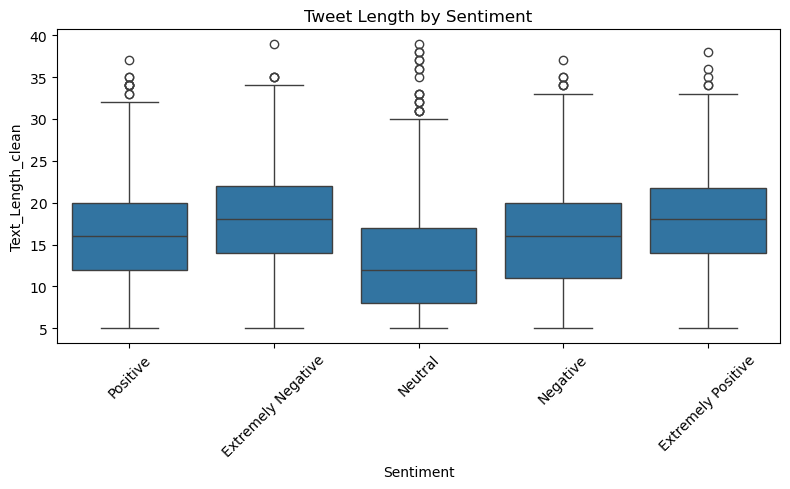

In [115]:
# Length of tweets
df['Text_Length_clean'] = df['cleaned_tweets'].astype(str).apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Sentiment', y='Text_Length_clean')
plt.title('Tweet Length by Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

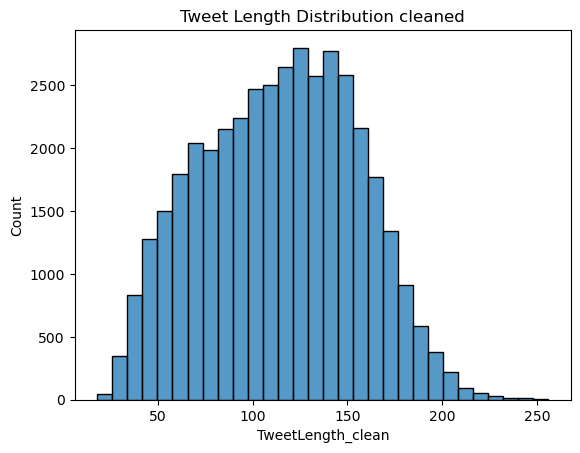

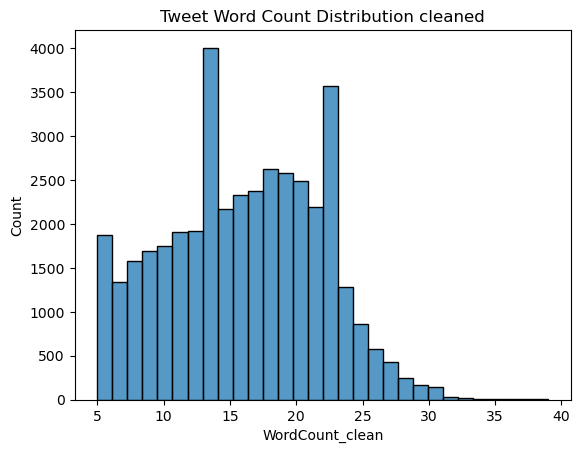

In [116]:
df['TweetLength_clean'] = df['cleaned_tweets'].apply(len)
df['WordCount_clean'] = df['cleaned_tweets'].apply(lambda x: len(x.split()))

sns.histplot(data=df, x='TweetLength_clean', bins=30)
plt.title("Tweet Length Distribution cleaned")
plt.show()

sns.histplot(data=df, x='WordCount_clean', bins=30)
plt.title("Tweet Word Count Distribution cleaned")
plt.show()

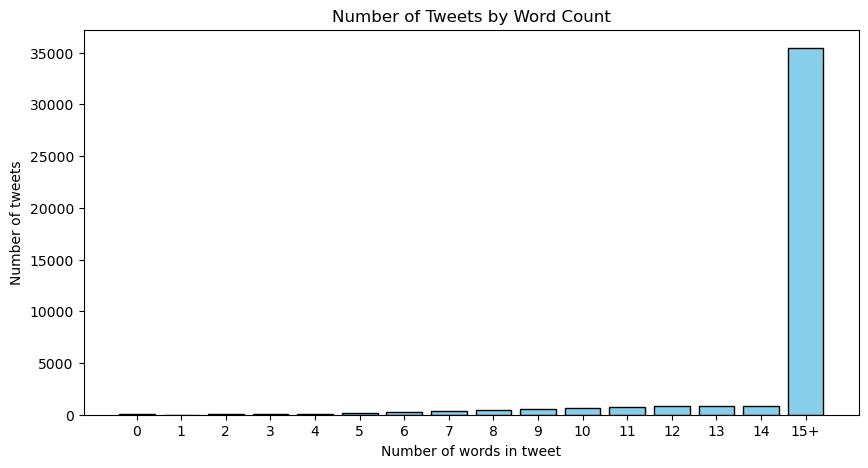

Tweets before filtering: 41157
Tweets after filtering (>=5 words): 40935


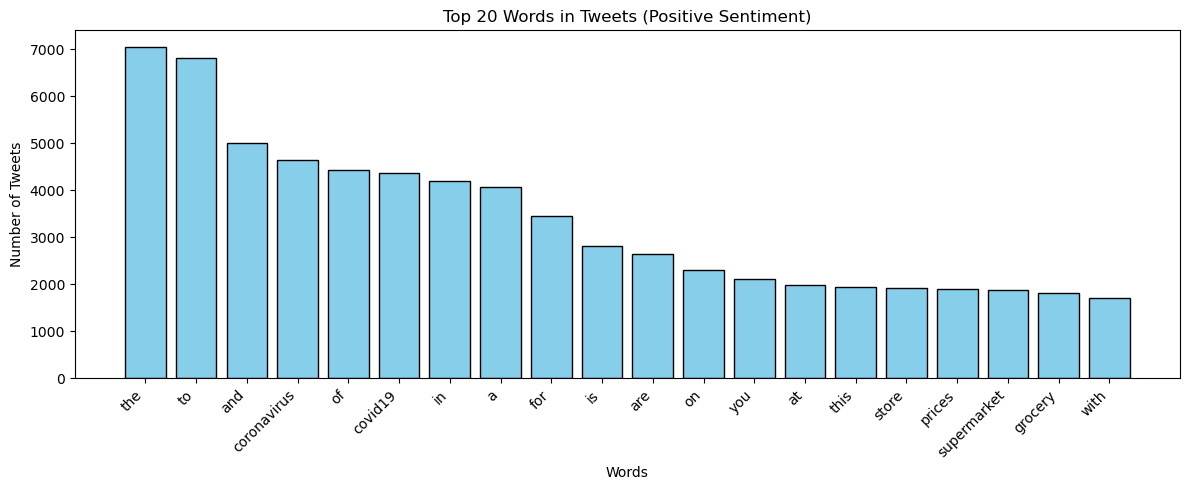

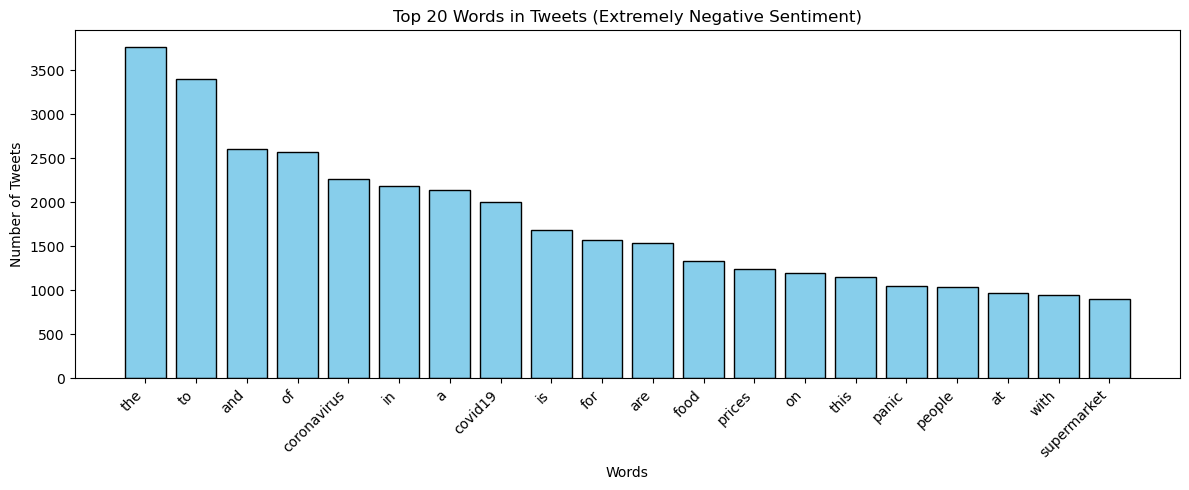

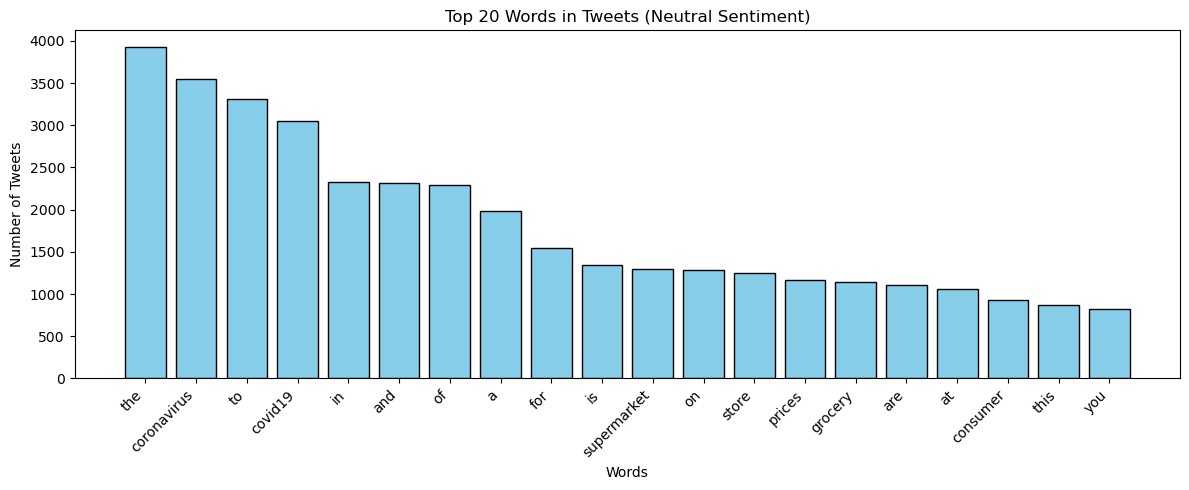

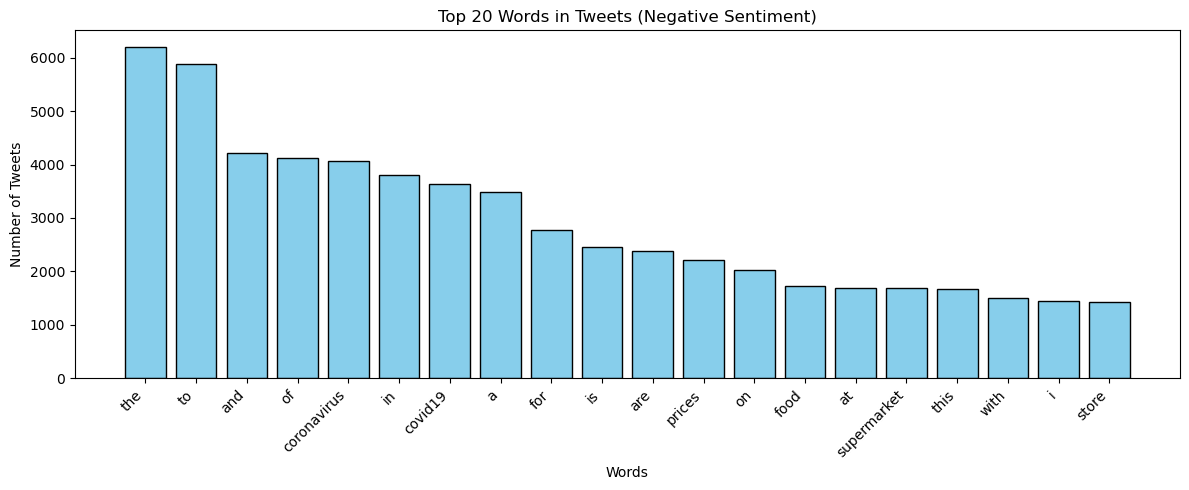

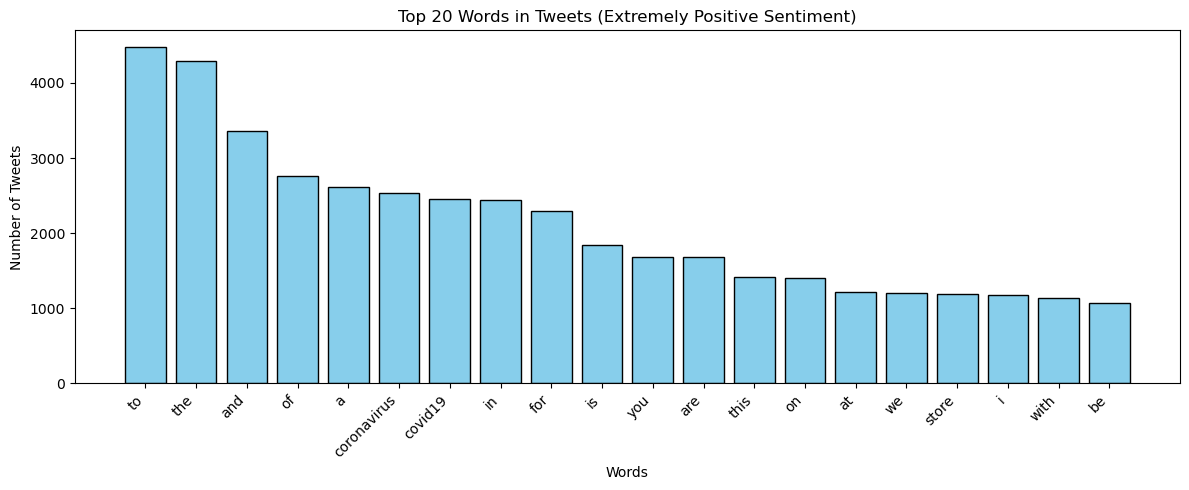

In [98]:
# --- פונקציות ניקוי בסיסי ---
def strip_emoji(text):
    return emoji.replace_emoji(text, replace='')

def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower()
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))
    return new_tweet2

def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) or ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

def clean_text(text):
    text = strip_emoji(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    return text.strip()

# --- ניקוי הטקסטים בדאטהפריים ---

df['cleaned_tweets'] = df['OriginalTweet'].astype(str).apply(clean_text)

# --- ספירת מילים ---

def count_words(text):
    return len(text.split())

df['word_count'] = df['cleaned_tweets'].apply(count_words)

# --- גרף התפלגות מפורט של מספר מילים ---

max_words = 15  # ניתן לשנות לפי הצורך

word_counts = df['word_count'].value_counts().sort_index()

# ודא שכל הערכים מ-0 ועד max_words קיימים ב-series
for i in range(max_words + 1):
    if i not in word_counts:
        word_counts[i] = 0

word_counts = word_counts.sort_index()

# אגד את כל הטוויטים עם מילים >= max_words לקטגוריה אחת
word_counts_plot = word_counts.loc[:max_words - 1].copy()
word_counts_plot[max_words] = word_counts.loc[max_words:].sum()

labels = [str(i) for i in range(max_words)]
labels.append(f'{max_words}+')

plt.figure(figsize=(10,5))
plt.bar(labels, word_counts_plot.values, color='skyblue', edgecolor='black')
plt.title('Number of Tweets by Word Count')
plt.xlabel('Number of words in tweet')
plt.ylabel('Number of tweets')
plt.show()

# --- סינון ציוצים עם פחות מ-5 מילים ---

df_filtered = df[df['word_count'] >= 5].copy()

print(f"Tweets before filtering: {len(df)}")
print(f"Tweets after filtering (>=5 words): {len(df_filtered)}")

# פונקציה עזר: סופר בכמה טוויטים מופיעה כל מילה
def compute_top_words_by_tweet_count(df_sentiment, top_n=20):
    word_tweet_count = defaultdict(int)

    for tweet in df_sentiment['cleaned_tweets']:
        words = set(tweet.split())  # set כדי לא לספור פעמיים באותו טוויט
        for word in words:
            word_tweet_count[word] += 1

    # ממיין לפי כמות טוויטים
    top_words = Counter(word_tweet_count).most_common(top_n)
    return pd.DataFrame(top_words, columns=['word', 'tweet_count'])

# עבור כל סנטימנט
sentiments = df_filtered['Sentiment'].unique()

for sentiment in sentiments:
    df_sent = df_filtered[df_filtered['Sentiment'] == sentiment]
    top_words_df = compute_top_words_by_tweet_count(df_sent)

    # ציור BAR CHART
    plt.figure(figsize=(12, 5))
    plt.bar(top_words_df['word'], top_words_df['tweet_count'], color='skyblue', edgecolor='black')
    plt.title(f"Top 20 Words in Tweets ({sentiment} Sentiment)")
    plt.ylabel('Number of Tweets')
    plt.xlabel('Words')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

The cleaning step left high-frequency, meaningless words that can interfere with the analysis.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amith\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amith\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


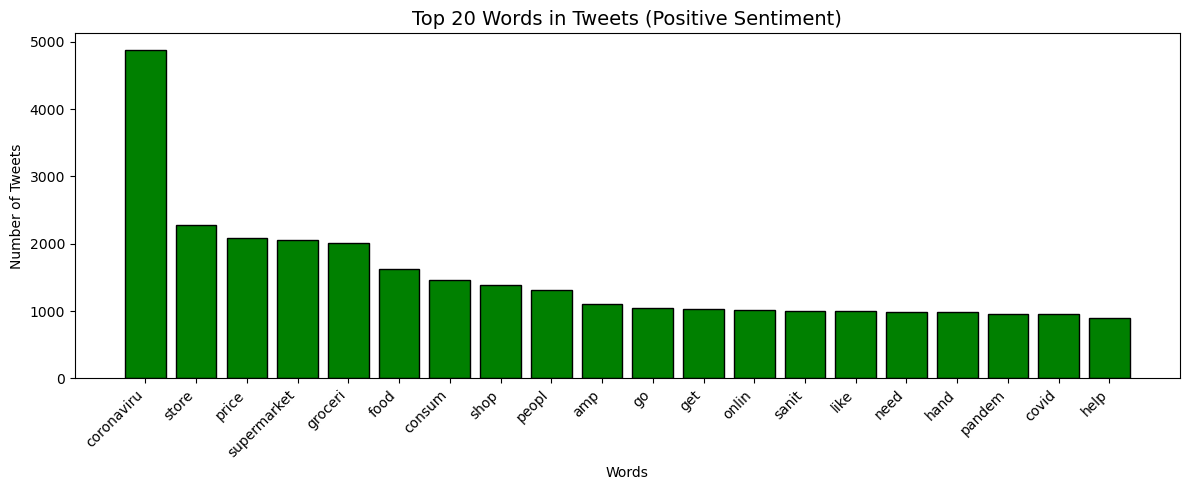

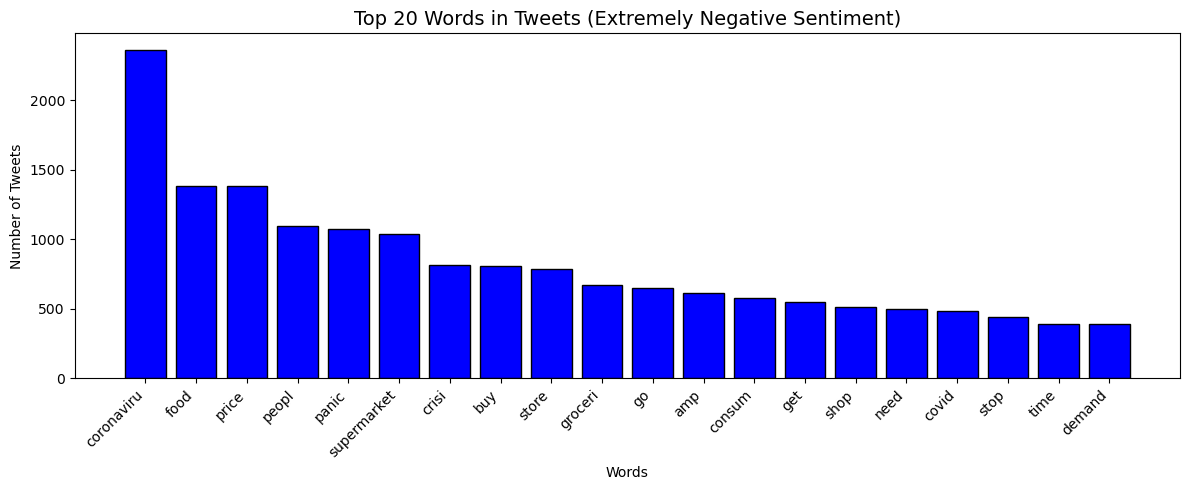

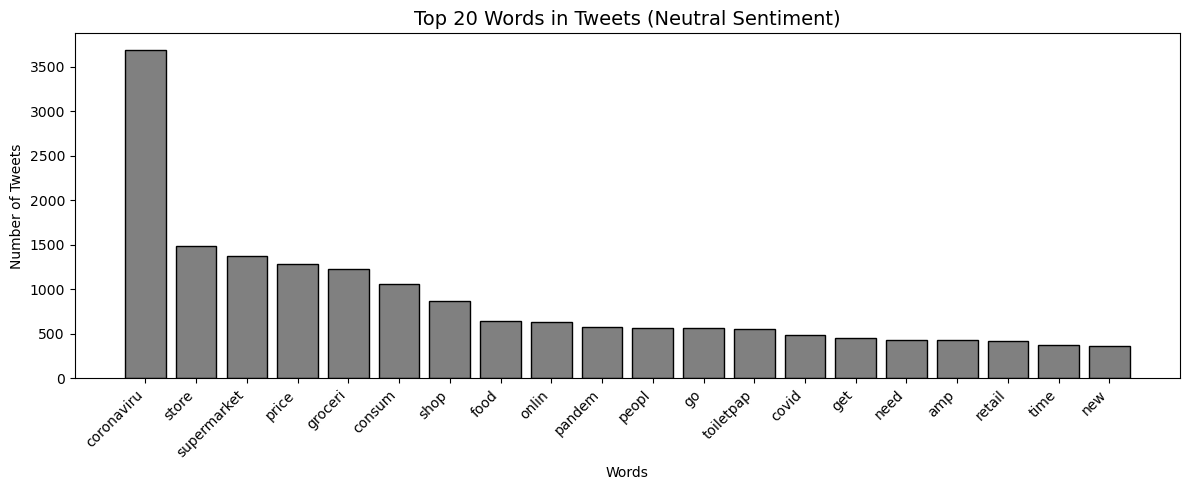

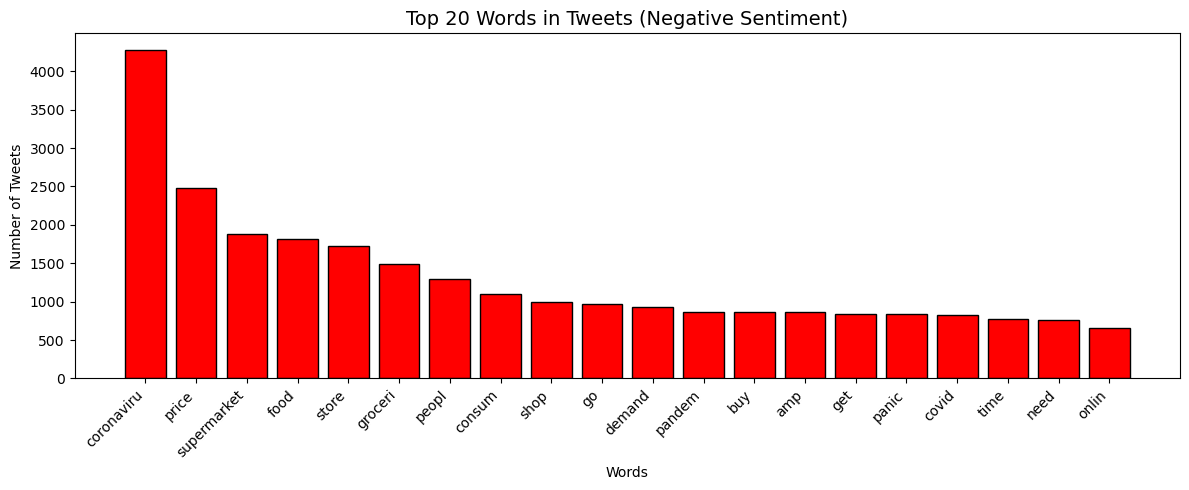

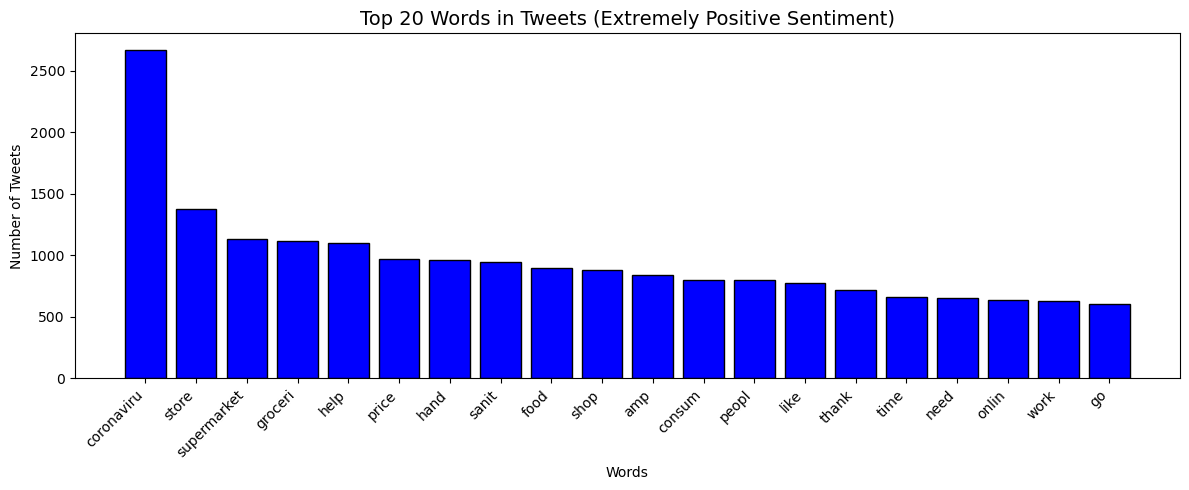

In [84]:
# --- הורדת משאבים של nltk ---
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# --- פונקציות ניקוי ---

def strip_emoji(text):
    return emoji.replace_emoji(text, replace='')

def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower()
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    banned_list = string.punctuation + 'Ã±ã¼â»§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))
    return new_tweet2

def filter_chars(a):
    return ' '.join(['' if ('$' in word or '&' in word) else word for word in a.split(' ')])

def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text).strip()

# --- ניקוי בסיסי של טקסט ---
def basic_clean_text(text):
    text = strip_emoji(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    return text

# --- הוספת ניקוי מתקדם: הסרת stopwords ו-stemming ---
def clean_text_stemming(text):
    words = nltk.word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words and word.isalpha()]
    stemmed_words = [stemmer.stem(word) for word in filtered_words]
    return ' '.join(stemmed_words)

# --- שלב 1: ניקוי מלא של הטקסט כולל stemming ---
df['cleaned_tweets'] = df['OriginalTweet'].astype(str).apply(basic_clean_text)
df['cleaned_tweets'] = df['cleaned_tweets'].apply(clean_text_stemming)

# --- שלב 2: ספירת מילים לאחר ניקוי ---
df['word_count'] = df['cleaned_tweets'].apply(lambda x: len(x.split()))

# --- שלב 3: סינון טוויטים עם פחות מ-5 מילים ---
df_filtered = df[df['word_count'] >= 5].copy()

# --- שלב 4: גרף מילים נפוצות לפי סנטימנט ---

sentiment_colors = {
    'Positive': 'green',
    'Negative': 'red',
    'Neutral': 'gray'
}

def compute_top_words_by_tweet_count(df_sentiment, top_n=20):
    word_tweet_count = defaultdict(int)
    for tweet in df_sentiment['cleaned_tweets']:
        words = set(tweet.split())
        for word in words:
            word_tweet_count[word] += 1
    return pd.DataFrame(Counter(word_tweet_count).most_common(top_n), columns=['word', 'tweet_count'])

sentiments = df_filtered['Sentiment'].unique()

for sentiment in sentiments:
    df_sent = df_filtered[df_filtered['Sentiment'] == sentiment]
    top_words_df = compute_top_words_by_tweet_count(df_sent)

    plt.figure(figsize=(12, 5))
    color = sentiment_colors.get(sentiment, 'blue')

    plt.bar(top_words_df['word'], top_words_df['tweet_count'], color=color, edgecolor='black')
    plt.title(f"Top 20 Words in Tweets ({sentiment} Sentiment)", fontsize=14)
    plt.ylabel('Number of Tweets')
    plt.xlabel('Words')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

The processing garbled the words and removed some letters.